![alt text](ames_iowa_downtown.avif "Ames downtown city")

The aim of the followinng project is to predict house sale prices in Ames town, Iowa, USA. Ames is a typical small provincial american town with a population around 66 thousand (according to the 2020 census). This example might be generalized to other small towns in the United States, especially in Iowa. However, the main reason why this notebook was ever created is to present the typical Data Science workflow when dealing with regression predictive type of problem.

# Presets

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import plotly.io as pio

from sklearn import decomposition
from statsmodels.stats.outliers_influence import variance_inflation_factor
from prince import MCA
from sklearn import metrics

# Models
from sklearn.ensemble import (
    RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor,
    HistGradientBoostingRegressor, StackingRegressor, VotingRegressor
)
from sklearn.linear_model import (
    LinearRegression, Lars, Lasso, LassoLars, Ridge, ARDRegression,
    ElasticNet, BayesianRidge, GammaRegressor, HuberRegressor, RANSACRegressor,
    PassiveAggressiveRegressor, TheilSenRegressor, RidgeCV
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRFRegressor, XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
from FunctionsEDA import *
from FunctionsFeatureSelection import *

np.random.seed(42)
pio.renderers.default = "browser"
pd.set_option('display.max_columns', 500)

In [3]:
data = pd.read_csv('train.csv')

# Basic statistics

In [ ]:
show_data(data)

- Rows/cols ratio seems to be pretty small, taking into consideration the fact that lot of variables are of type 'object'. Thus, dimensionality reduction must be held for sure

- MiscFeature is totally absent?
- PoolQC, FireplaceQu, Alley, Fence may be absent rather due to natural reasons (just no fireplaces, pools in the house)
- Others must be ivestigated more throughly

- There are significant outliers almost in every variable
- Most of the houses were sold before the global financal crisis
- All of the houses were build before 2010

# Qualitative (business) analysis

With the statistics shown above, we will try to analize and predict the influence of each variable in the sale price. Each variable will be given a predifined influence (low, medium, high) and the corresponding effect sign(stimulant, distimulant, mixed)

In [ ]:
stim_vec = [
    'n', 'm', 'm', 's', 's', 's', 's', 'd', 'd',
    's', 'd', 'd', 'm', 'm', 'm', 'm', 'm', 'd', 'd',
    's', 'd', 'm', 'm', 'm', 'm', 'm', 'm', 'm',
    'm', 'd', 'd', 's', 'd', 'd', 'm',  'm', 'd', 's',
    'm', 'd', 'm', 'm',
    's', 's', 'd', 's', 's', 's', 's', 's', 's', 's', 's', 'd', 's', 'd', 's', 'd',
    's', 'd', 'm', 's', 's', 'd', 'd',
    's', 's', 's', 's', 's',
    's', 'd', 'd', 's', 's', 's', 'm', 'm', 's', 's', 'n'
]
imp_vec = [
    'l', 'l', 'h', 'l', 'h', 'l', 'm', 'm', 'l',
    'h', 'm', 'l', 'm', 'h', 'h', 'h', 'l', 'm', 'm',
    'h', 'h', 'l', 'l', 'l', 'l', 'l', 'l', 'l',
    'l', 'l', 'l', 'm', 'm', 'm', 'l', 'l', 'l', 'm',
    'l', 'm', 'l', 'l',
    'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'm', 'l', 'l', 'm', 'l', 'l', 'l',
    'm', 'l', 'l', 'l', 'l', 'l', 'l', 
    'l', 'l', 'l', 'l', 'l',
    'm', 'l', 'm', 'm', 'l', 'l', 'm', 'm', 'l', 'l', 'n'
]

quantitative_eda(data, stim_vec, imp_vec)

Additional:
- some variables need recoding
- lots of variables seems to be strongly correlated with each other - thus, dimensionality reduction techniques should be applied

# Initial EDA

In [4]:
X = data.copy()

## Numeric

In [5]:
X['MSSubClass'] = X['MSSubClass'].astype(str)
X['PorchType_WoodDeck'] = np.where(X['WoodDeckSF'] != 0, 1, 0)
X['PorchType_OpenPorchSF'] = np.where(X['OpenPorchSF'] != 0, 1, 0)
X['PorchType_Enclosed'] = np.where(X['EnclosedPorch'] != 0, 1, 0)
X['PorchType_Screen'] = np.where(X['ScreenPorch'] != 0, 1, 0)
X['PorchType_3SsnPorch'] = np.where(X['3SsnPorch'] != 0, 1, 0)
X['IsBsmFin'] = np.where(X['BsmtUnfSF'] != 0, 1, 0)
X['IsFireplace'] = np.where(X['Fireplaces'] != 0, 1, 0)
X['IsMiscVal'] = np.where(X['MiscVal'] != 0, 1, 0)
X['IsLowQual'] = np.where(X['LowQualFinSF'] != 0, 1, 0)

X['PerRoomSF'] = X['GrLivArea']/X['TotRmsAbvGrd']
X['PorchSF'] = (X['WoodDeckSF'] + X['OpenPorchSF'] + 
                X['EnclosedPorch'] + X['3SsnPorch'] + 
                X['ScreenPorch'])

X['TotalBaths'] = X['BsmtFullBath']+0.5*X['BsmtHalfBath']+X['FullBath']+X['HalfBath']*0.5

X['FloorRatio'] = X['2ndFlrSF']/X['1stFlrSF']
X['BsmFinUnfRatio'] = X['BsmtUnfSF']/X['TotalBsmtSF']
X['BsmLowQualRatio'] = X['LowQualFinSF']/X['TotalBsmtSF']
X['BsmFin2BsmFin1Ratio'] = X['BsmtFinSF2']/X['BsmtFinSF1']
X['GarageLivRatio'] = X['GarageArea']/X['GrLivArea']

X['KitchenRatio'] = X['KitchenAbvGr']/X['TotRmsAbvGrd']
X['BathRatio'] = X['TotalBaths']/X['TotRmsAbvGrd']
X['BedroomRatio'] = X['BedroomAbvGr']/X['TotRmsAbvGrd']

In [6]:
show_data(X)

Head:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PorchType_WoodDeck,PorchType_OpenPorchSF,PorchType_Enclosed,PorchType_Screen,PorchType_3SsnPorch,IsBsmFin,IsFireplace,IsMiscVal,IsLowQual,PerRoomSF,PorchSF,TotalBaths,FloorRatio,BsmFinUnfRatio,BsmLowQualRatio,BsmFin2BsmFin1Ratio,GarageLivRatio,KitchenRatio,BathRatio,BedroomRatio
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,0,1,0,0,0,1,0,0,0,213.750000,61,3.5,0.997664,0.175234,0.0,0.0,0.320468,0.125000,0.437500,0.375000
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1,0,0,0,0,1,1,0,0,210.333333,298,2.5,0.000000,0.225040,0.0,0.0,0.364501,0.166667,0.416667,0.500000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,0,1,0,0,0,1,1,0,0,297.666667,42,3.5,0.941304,0.471739,0.0,0.0,0.340426,0.166667,0.583333,0.500000
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,0,1,1,0,0,1,1,0,0,245.285714,307,2.0,0.786681,0.714286,0.0,0.0,0.373908,0.142857,0.285714,0.428571
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,1,1,0,0,0,1,1,0,0,244.222222,276,3.5,0.919651,0.427948,0.0,0.0,0.380346,0.111111,0.388889,0.444444



Nrows: 1460
Ncols: 101
rows/cols ratio: 14.455445544554456 

Col types:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PorchType_WoodDeck,PorchType_OpenPorchSF,PorchType_Enclosed,PorchType_Screen,PorchType_3SsnPorch,IsBsmFin,IsFireplace,IsMiscVal,IsLowQual,PerRoomSF,PorchSF,TotalBaths,FloorRatio,BsmFinUnfRatio,BsmLowQualRatio,BsmFin2BsmFin1Ratio,GarageLivRatio,KitchenRatio,BathRatio,BedroomRatio
0,int64,object,object,float64,int64,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object,object,int64,object,int64,int64,int64,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object,int64,object,object,float64,object,int64,int64,object,object,object,int64,int64,int64,int64,int64,int64,object,object,object,int64,int64,int64,object,object,int64,int32,int32,int32,int32,int32,int32,int32,int32,int32,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64


Number of integer columns: 35
Number of float columns: 13
Number of string columns: 44 

NaNs:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PorchType_WoodDeck,PorchType_OpenPorchSF,PorchType_Enclosed,PorchType_Screen,PorchType_3SsnPorch,IsBsmFin,IsFireplace,IsMiscVal,IsLowQual,PerRoomSF,PorchSF,TotalBaths,FloorRatio,BsmFinUnfRatio,BsmLowQualRatio,BsmFin2BsmFin1Ratio,GarageLivRatio,KitchenRatio,BathRatio,BedroomRatio
0,0,0,0,259,0,0,1369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,37,37,38,37,0,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,690,81,81,81,0,0,81,81,0,0,0,0,0,0,0,1453,1179,1406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,36,467,0,0,0,0



Infs:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PorchType_WoodDeck,PorchType_OpenPorchSF,PorchType_Enclosed,PorchType_Screen,PorchType_3SsnPorch,IsBsmFin,IsFireplace,IsMiscVal,IsLowQual,PerRoomSF,PorchSF,TotalBaths,FloorRatio,BsmFinUnfRatio,BsmLowQualRatio,BsmFin2BsmFin1Ratio,GarageLivRatio,KitchenRatio,BathRatio,BedroomRatio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0



Statistics:


,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,PorchType_WoodDeck,PorchType_OpenPorchSF,PorchType_Enclosed,PorchType_Screen,PorchType_3SsnPorch,IsBsmFin,IsFireplace,IsMiscVal,IsLowQual,PerRoomSF,PorchSF,TotalBaths,FloorRatio,BsmFinUnfRatio,BsmLowQualRatio,BsmFin2BsmFin1Ratio,GarageLivRatio,KitchenRatio,BathRatio,BedroomRatio
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1423.000000,1424.0,993.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890,0.478767,0.550685,0.142466,0.079452,0.016438,0.919178,0.527397,0.035616,0.017808,230.905362,181.329452,2.210616,0.358380,0.551303,inf,0.411632,0.323993,0.169059,0.346723,0.444893
std,421.610009,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883,0.499720,0.497595,0.349647,0.270536,0.127198,0.272655,0.499420,0.185395,0.132299,44.740397,156.656097,0.785399,0.446071,0.361698,NaN,2.478674,0.148638,0.047631,0.120470,0.098361
min,1.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.111111,0.000000
25%,365.750000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,199.000000,45.000000,2.000000,0.000000,0.229432,0.0,0.000000,0.246751,0.142857,0.250000,0.400000
50%,730.500000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.0


Unique values (object):

MSSubClass       [60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...
MSZoning                                 [RL, RM, C (all), FV, RH]
Street                                                [Pave, Grvl]
Alley                                            [nan, Grvl, Pave]
LotShape                                      [Reg, IR1, IR2, IR3]
LandContour                                   [Lvl, Bnk, Low, HLS]
Utilities                                         [AllPub, NoSeWa]
LotConfig                      [Inside, FR2, Corner, CulDSac, FR3]
LandSlope                                          [Gtl, Mod, Sev]
Neighborhood     [CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...
Condition1       [Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...
Condition2       [Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...
BldgType                     [1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]
HouseStyle       [2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...
RoofStyle               [Gable, Hip,

In [ ]:
cols_to_fill = [
    'LotFrontage', 'MasVnrArea', 
    'BsmFin2BsmFin1Ratio', 'BsmLowQualRatio', 'BsmFinUnfRatio', 'BsmFinUnfRatio'
]
for i in cols_to_fill:
    X[i] = X[i].fillna(0)
    
X['BsmLowQualRatio'] = X['BsmLowQualRatio'].replace([np.inf, -np.inf], 1)

In [ ]:
tmp = show_plots_single(X, 'SalePrice', f_size=7, p_height=3000)

In [ ]:
#tmp['num_single'].show()
tmp['num_split'].show()
tmp['num_split_rid'].show()
tmp['num_vs_y_split'].show()

In [ ]:
tmp['num_split_hist'].show()

180921.19589041095

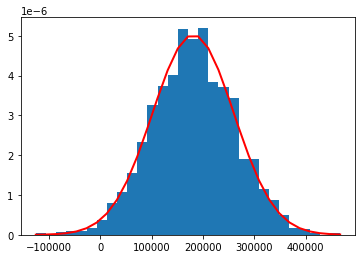

In [25]:
mu = X['SalePrice'].mean()
sigma = X['SalePrice'].std()

s = np.random.normal(mu, sigma, len(X['SalePrice']))
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins,
         1/(sigma*np.sqrt(2 * np.pi))*np.exp(-(bins-mu)**2/(2 * sigma**2)),
         linewidth=2, color='r')
plt.show()

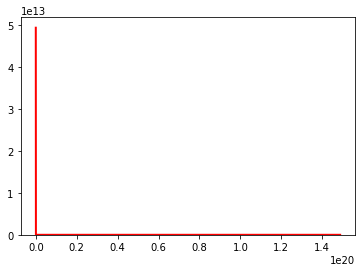

In [41]:
mu = np.std(np.log(X['SalePrice']))
sigma = np.mean(np.log(X['SalePrice']))
s = np.random.lognormal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, 1000, density=True)
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
#plt.axis('tight')
plt.show()

In [12]:
bins

array([-76573.19411723, -57787.6933652 , -39002.19261317, -20216.69186114,
        -1431.1911091 ,  17354.30964293,  36139.81039496,  54925.31114699,
        73710.81189903,  92496.31265106, 111281.81340309, 130067.31415512,
       148852.81490716, 167638.31565919, 186423.81641122, 205209.31716325,
       223994.81791528, 242780.31866732, 261565.81941935, 280351.32017138,
       299136.82092341, 317922.32167545, 336707.82242748, 355493.32317951,
       374278.82393154, 393064.32468358, 411849.82543561, 430635.32618764,
       449420.82693967, 468206.3276917 , 486991.82844374])

In [ ]:
fig2 = ff.create_distplot(hist_data, group_labels, curve_type = 'normal')
normal_x = fig2.data[1]['x']
normal_y = fig2.data[1]['y']
#And then inlclude those values in the first fig using fid.add_trace(go.Scatter()) like this:

fig2 = ff.create_distplot(hist_data, group_labels, curve_type = 'normal')
normal_x = fig2.data[1]['x']
normal_y = fig2.data[1]['y']
fig.add_traces(go.Scatter(x=normal_x, y=normal_y, mode = 'lines',
                          line = dict(color='rgba(0,255,0, 0.6)',
                                      #dash = 'dash'
                                      width = 1),
                          name = 'normal'
                         ))
fig.show()

- **Id** column must be dropped
- **MSSubClass**, **OverallQual**, **OverallCond** must be recoded as str
- **LotFrontage**, **LotArea**, **MasVnrArea**, **BsmtFinSF1**, **BsmtFinSF2**, **BsmtUnfSF**, **TotalBsmtSF**, **1stFlrSF**, **2stFlrSF**, **GrLivArea**, **GarageArea**, **LotPrice** distributions show big positive skewness => potential outliers
- **LowQualFinSF**, **WoodDeckSF**, **OpenPorchSF**, **EnclosedPorch**, **3SsnPorch**, **ScreenPorch**, **PoolArea**, **MiscVal** have poor right-skewed distributions with significant outliers

------------------------------------------------------------------------------------------------------

- There are 3 significant centers of YearBuilt: 1921-22, 1964-1965, 2002
- The dominant renovation year was 2003
- Most of the garages were built in 1966 and 2002; reminds YearBuilt distribution after 60s
- most of the garages allow for 2 cars; proportion of 1/3 is alomost the same

------------------------------------------------------------------------------------------------------

- Most of the houses has 0 or 1 bath; Half baths is very rare
- Most of the houses has 3 rooms; 2 and 4 are also quite popular, whereas rooms >5 - more like outliers
- Almost all of the houses have 1 kitchen
- In total, more than 10 rooms is an outlier
- Most of the houses have either 0 or 1 fireplaces; some have 2;
- Most of the houses do not have wood deck or open/enclosed/3 season/screen porch

------------------------------------------------------------------------------------------------------

- Most of the houses were sold during June (generally, not in autumn)
- YearSold distribution is almost unimodal

To sum up:
- YearSold, MiscVal, ID are not important
- Decks and porches sq. ft. could be united into some new feature as distributions reminds each other
- Other areas could also be united into some new feature as distributions reminds each other
- Garage Year and Built Year seems to be correlated a lot

- LotFrontage > 80 are outliers with max=312

- Majority of houses are in average condition, but the number of houses in better condition is bigger than in worser condition
- Majory of houses' quality is above average, which may signify expert's bias during the valuation. Moreover, none ofthe house gained 10. May be considered non-informative due to these facts
- Number of houses built in 1966+1922 = number of houses built in 2002
- Renovation boom occured in 2002, before that - quite unimodal besides 1951
-------------------------------------------------------------------------------------------------------

- 75% of LotArea is below 11k; some accumulation within 18-35k, 46-70 and 4 extra outliers
- MasVnrArea has 2 accumulations: major (below 165) and minor (420-1170) with 2 outliers
- BsmtFinSF1 has 2 groups: around 0 and around 608sq.ft with minor group around 200 and 1 outlier
- BsmtFinSF2 almost equals to 0
- LowQualFinSF almost equals to 0
- BsmtUnfSF is much better - no significant outliers
- TotalDsmtSF, 1stFlrSF, GrLivArea, MasVnrArea are almost perfectly correlated
- 2ndFlrSF is mostly 0, but the other group is 762 sq.ft. No outliers

-------------------------------------------------------------------------------------------------------

- Number of full basement baths mostly 0 or 1, some observations for 2, 3 -- outlier
- basement HalfBath almost equals to zero
- HalfBath almost equals to zero
- FullBath - either 1, 2 or 3; drop the rest
- Bedrooms = 4,5,6 or 8 -- outliers
- Kitchen = 0,2,3 - outliers
- But  something strange with total rooms variable - only 1 outlier (14), with median = 6
- 3 fireplaces - outlier

-------------------------------------------------------------------------------------------------------

- GarageYearBlt more like YearBlt - see comparison
- Garage cars = 4 - outlier
- GarageArea more like grLivArea

-------------------------------------------------------------------------------------------------------

- WoodDeckSF, OpenPorchSF are more alike
- EnclosedPorch, 3SsnPorch, ScreenPorch are much more rare, allmost equals to zero

-------------------------------------------------------------------------------------------------------

- PoolArea - only 7 houses with pools
- MscVal - almost equals to zero
- YrSold is defenitely unimodal
- Sale price distribution looks like total lot sq.feet distribution

Before moving futher, sum up single numerical dstributions:
- Drop rather not important: **YrSold**, **PoolArea**, **MscVal**, **GarageYearBlt**, **BsmtFullBath**,  **BsmtHalfBath**, **HalfBath**, **BsmtFinSF2**, **LowQualFinSF**, **Id**, 
- Unite **EnclosedPorch**, **3SsnPorch**, **ScreenPorch** into **PorchRare**
- Unite **WoodDeckSF**, **OpenPorchSF** into **PorchUsual**
- Unite + remove outliers: **GarageArea**, **grLivArea**, **LotArea**, **TotalDsmtSF**, **1stFlrSF**, **MasVnrArea**
- Remove outliers: **GarageCars**, **Kitchen**, **Fireplaces**, **FullBath**, **Bedroom**. Check correlation with sq.ft. or use **TotRmsAbvGrd** instead
- Keep as it is: **MoSold**, **Sale price**, **BsmtUnfSF**, **BsmtFinSF1**, **TotRmsAbvGrd**, **LotFrontage**, **OverallCond**, **OverallQual**(more factors to study to decide), **YearBuilt**, **YearRemodAdd**, **SalePrice**
- Create one-hot: IsSecondFloor
- Recode as str: **MSSubClass**, **GarageCars**, **Kitchen**, **Fireplaces**, **FullBath**, **Bedroom**, **TotRmsAbvGrd**, **OverallCond**, **OverallQual**

## Numerical (2d)

- LotArea and TotalBsmtSF are correlated
- LotArea and GrLivArea are correlated
\
= > keep LotArea only 

- LotArea and 1stFlrSF are correlated
- LotArea and MasVnr are correlated
\
= > keep LotArea only

LotArea and GarageArea are correlated
\
= > keep LotArea only

To sum up:
- **LotArea** correlated with all the other areas, **LotFrontage**, 
- **WoodDeckSF** seems to be correlated with all the other porches
- seems not to be important as much: **KitchenAbvGr**, **Fireplaces**, **BedroomAbvGr**, **FullBath**, **MoSold**
- seems to be important: **GarageCars**, **TotRmsAbvGrd**, **YearRemodAdd**, **YearBuilt**, **OverallQual**, **OverallCond**, **BsmtUnfSF**, **WoodDeckSF**, **LotArea**
\
=> out we have 9+1 (MSSubClass) out of 38 vars important 

In [ ]:
data.hist(layout=(6, 7), figsize=(20, 15), bins=40)
plt.show()

In [ ]:
#sns.pairplot(data, diag_kind="kde")

- Again, it seems like strong correlation patterns are visible only for the Area-based variables

## Categorical

- **MsZoning**: think about removing uniting RM, RH, something with C
- **Street**: Only 6 streets are gravel, rather remove
- **Alley**: is almost unimodal, rather remove
- **Utilities**: only 1 house does not have all public utilities, rather remove
- **CentraAir**: rather rare variable
- **NeightboorHood**: maybe too many categories?
- **HeatingQC**: drop Po?

-------------------------------------------------------------------------------------------------------

- Restrict number of categories: **Condition1**, **Condition2**, **RoofStyle**, **ExterCond**, **Exterior1st**, **Exterior2nd**, **BsmtCond**, **BsmntFinType2**, **GarageType**, **SaleType**, **SaleCondition**
- Keep as it is: **MasVnrType**, **ExterQual**, **HouseStyle**, **BldgType**, **Foundation**, **BsmtQual**, **BsmtExposure**, **BsmntFinType1**, **KitchenQual**, **FireplaceQu**, **GarageFinish**, **PavedDrive**, **PoolQC**, **Fence**, **MiscFeature**

-------------------------------------------------------------------------------------------------------

- **LotConfig**: recode into Inside, Corner, CulDSac, Frontage
- **LandSlope**: recode into Slope, NoSlope
- **LotShape**: recode into Regular, Irregular, VeryIrregular
- **LandCountour**: recode into NearFlat, NotNearFlat
- **RoofMaterial** - recode into Cheap, Costly
- **Heating**: recode into Gas, NotGas
- **Elecrical**: recode into Good, Average, Bad
- **Functional**: recode into Typical, Minor, Major
- **GarageQual**: recode into Good, Average, Bad
- **GarageCond**: recode into Good, Average, Bad

- hard to perform EDA, too many variables, perform later after dimensionality reduction

- **MasnrType**: Masonry veneer with stone is costs much more; None and BrkCmn could be united into single variable
- keep as it is: **HouseStyle**, **Foundation**, **KitchenQual**, **FireplaceQu**, **GarageFinish**, **MiscFeature**, **GarageType**
- **BldgType**: maybe 2fmCon and Duplexcould be united into one; the ame for 1Fam and TwnhsE
- **BsmtQual**: less distinctions between groups, but for now keep as it is
- **BsmtExposure**: rather not important
- **BsmtFinType1**: rather recode into GLQ, Unf, Other
- **PavedDrive**: hard to say
- **PoolQC**: Fa and Gd are almost the same
- **Fence**: recode as GoodPrivacy, NotGoodPrivacy
- **Condition1**, **Condition2**: unite PosA, PosN into Park; RRAe, RRAn, RRNe into RailRoad
- hard to say: **RoofType**, **Exterior1st**, **Exterior2nd**
-  **BsmtFinType2**: maybe unite BLQ, Rec, LwQ
- **otConfig**: maybe unite FR3 and CulDSac
- **LandSlope**: unite Mod and Sev
- **LotShape**: Reg much lower
- **LandContour**: maybe Lvl+bank, Low+HLS
- **RoofMatl**: for sure CompShg+Metal+Roll+ClyTile, WdShake+Membran
- **Heating**: for sure Gas, NoGas
- **Electrical**: either 0-1 or factor(3)
- **Functional**: no big difference besides Maj2
- **HeatingQC**: maybe unite Po with Fa
- **Neighborhood**:
  - CollgCr+Crawfor+ClearCr+Blmngtn
  - Veenker+Somerst+Timber
  - NoRidge+NridHt+StoneBr
  - Blueste+SWISU+Sawyer
  - Mitchel+NAmes+NPkVill
  - NWAmes+SawyerW+Gilber
  - OldTown+BrkSide+Edwards
  - IDOTRR+MeadowV+BrDale

Numerical:
- keep **LotArea** (or other more important feature with sq.ft. / newly created one from PCA)
- keep **WoodDeckSF** (or other more important feature ending with porch / newly created one from PCA)
- keep as it is: **GarageCars**, **TotRmsAbvGrd**, **YearRemodAdd**, **YearBuilt**,  **BsmtUnfSF**
- recode as str and explore: **MSSubClass**, **OverallCond**, **OverallQual**
- total: 10

------------------------------------------------------------------------------------------------------

Categorical:
- keep as it is: **MsZoning**, **CentralAir**, **HouseStyle**, **Foundation**, **KitchenQual**, **FireplaceQu**, **GarageFinish**, **MiscFeature**, **GarageType**, **PavedDrive**, **BsmtQual**, **RoofType**, **Exterior1st**, **Exterior2nd**, **Heating**, **GarageQual**, **GarageCond**
- **MasnrType**:  None+BrkCmn
- **BldgType**: 2fmCon+Duplex; 1Fam+TwnhsE
- **PoolQC**: Fa+Gd
- **BsmtFinType2**: BLQ+Rec+LwQ
- **LandContour**: Lvl+bank; Low+HLS
- **LandSlope**: Mod+Sev
- **LotConfig**: FR3+CulDSac
- **HeatingQC**: Po+Fa
- **RoofMatl**: CompShg+Metal+Roll+ClyTile; WdShake+Membran
- **Condition1**, **Condition2**: unite PosA, PosN into Park; RRAe, RRAn, RRNe into RailRoad
- **BsmtFinType1**: rather into GLQ, Unf, Other
- **Fence**: recode into GoodPrivacy, NotGoodPrivacy
- **Heating**: for sure recode into Gas, NoGas
- **Neighborhood**: CollgCr+Crawfor+ClearCr+Blmngtn, Veenker+Somerst+Timber, NoRidge+NridHt+StoneBr, Blueste+SWISU+Sawyer, Mitchel+NAmes+NPkVill, NWAmes+SawyerW+Gilber, OldTown+BrkSide+Edwards, IDOTRR+MeadowV+BrDale
- **LotShape**: Reg much lower
- **Electrical**: either 0-1 or factor(3)
- total: 33

-------------------------------------------------------------------------------------------------------
=> 43 initial variables to keep

# Correlation & outliers analysis

In [ ]:
def prepare_data_num(X):
    
    
    cols_to_drop = [
        'Id', 'MoSold', 'YrSold', 'PoolArea', 'BsmtFullBath', 'BsmtHalfBath', 
        'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'YearRemodAdd', 'TotalBsmtSF', 'MiscVal', '2ndFlrSF', '1stFlrSF',
        'LowQualFinSF', 'OverallCond', 'BsmtFinSF2', 'TotRmsAbvGrd'
    ]
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def prepare_data_cat(X):
    X['MSZoning'] = X.MSZoning.replace({'RH':'RM', 'FV':'RL', 'C (all)': 'RM'})
    X['IsLowDensityArea'] = np.where(X['MSZoning'] == 'RL', 1, 0)
    
    X['Neighborhood'] = X.Neighborhood.replace(
        {'Edwards': 'C0', 'OldTown': 'C0', 'Sawyer': 'C0', 'BrkSide': 'C0',
         'Blueste': 'C0', 'NPkVill': 'C0', 'Mitchel': 'C0', 'SWISU': 'C0', 'NAmes': 'C0',
         'MeadowV': 'C1', 'BrDale': 'C1', 'IDOTRR': 'C1',
         'NridgHt': 'C2', 'StoneBr': 'C2', 'NoRidge': 'C2',
         'SawyerW': 'C3', 'Blmngtn': 'C3', 'Gilbert': 'C3', 'NWAmes': 'C3',
         'Somerst': 'C4', 'Timber': 'C4', 'Veenker': 'C4',
         'Crawfor': 'C4', 'CollgCr': 'C4', 'ClearCr': 'C4',
        }
    )
    
    X['Condition1'] = X['Condition1'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition2'] = X['Condition2'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition1'] = np.where(X['Condition1'] == 'C1', 1, 0)
    X['Condition2'] = np.where(X['Condition2'] == 'C1', 1, 0)
    X['IsEnvGood'] = np.where(X['Condition2']+X['Condition1'] == 2, 1, 0)
    
    X['Alley'] = X.Alley.fillna('Pave')
    X['IsAlleyGravel'] = np.where(X['Alley'] == 'Pave', 0, 1)
    X['IsShapeReg'] = np.where(X['LotShape'] ==  'Reg', 1, 0)
    X['LandContour'] = X['LandContour'].replace(
        {'Lvl': 'Norm', 'Bnk': 'Norm', 'Low': 'Ir', 'HLS': 'Ir'}
    )
    X['IsLandFlat'] = np.where(X['LandContour'] == 'Ir', 0, 1)
    
    X['LotConfig'] = X['LotConfig'].replace(
        {'Inside': 'Norm', 'FR2': 'Norm', 'Corner': 'Norm', 'CulDSac': 'Ir', 'FR3': 'Ir'}
    )
    X['IsNarrow'] = np.where(X['LotConfig'] == 'Ir', 0, 1)
    X['IsSlope'] = np.where((X['LandSlope'] == 'Mod') | (X['LandSlope'] == 'Sev'), 1, 0)
    X['IsPaved'] = np.where((X['PavedDrive'] == 'N') | (X['PavedDrive'] == 'P'), 0, 1)
    
    X['MSSubClass'] = X['MSSubClass'].replace(
        {'20': 'C0', '70': 'C0', '75': 'C0', '80': 'C0',
         '60': 'C1', '120': 'C1',
         '90': 'C2', '85': 'C2', '40': 'C2', '160': 'C2', '50': 'C2', '190': 'C2',
         '45': 'C3', '30': 'C3', '180': 'C3'
        }
    )
    X['IsOneFamily'] = np.where(X['BldgType'] == '1Fam', 1, 0)
    X['IsOneFloor'] = X['HouseStyle'].replace(
        {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
         '1.5Fin': '1', '1.5Unf': '1',
         '2Story': '0', '2.5Fin': '0', '2.5Unf': '0'
        }
    ).astype(np.int64)
    X['IsRoofGable'] = np.where(X['RoofStyle'] == 'Gable', 1, 0)
    X['IsRoofStandard'] = np.where(X['RoofMatl'] == 'CompShg', 1, 0)
    X['Exterior_1'] = X['Exterior1st'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['Exterior_2'] = X['Exterior2nd'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['MasVnrType'] = X['MasVnrType'].fillna('None')
    X['MasVnrType'] = X['MasVnrType'].replace({'BrkFace': 'Brick', 'BrkCmn': 'Brick'})
    X['IsExtQualGood'] = np.where((X['ExterQual'] == 'Ex') | (X['ExterQual'] == 'Good'), 1, 0)
    X['IsExtCondGood'] = np.where((X['ExterCond'] == 'Ex') | (X['ExterCond'] == 'Good'), 1, 0)
    
    X['IsBsmConcrete'] = np.where(X['Foundation'] == 'PConc', 1, 0)
    
    X['BsmtCond'] = X['BsmtCond'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['BsmtCond'] = X['BsmtCond'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsBsmQualGood'] = np.where((X['BsmtQual'] == 'Ex') | (X['BsmtQual'] == 'Good'), 1, 0)
    X['IsBsmCondGood'] = np.where((X['BsmtCond'] == 'Ex') | (X['BsmtCond'] == 'Good'), 1, 0)
    
    X['BsmtExposure'] = X['BsmtExposure'].fillna('Absent')
    X['BsmExposure'] = X['BsmtExposure'].replace(
        {'Mn': 'Norm', 'Av': 'Norm', 'Absent': 'No'}
    )
    
    X['BsmtFinType1'] = X['BsmtFinType1'].fillna('Absent')
    X['BsmFinType_1'] = X['BsmtFinType1'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LwQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    X['BsmtFinType2'] = X['BsmtFinType2'].fillna('Absent')
    X['BsmFinType_2'] = X['BsmtFinType2'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LWQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    
    X['GarageType'] = X['GarageType'].fillna('Absent')
    X['GarageType'] = X['GarageType'].replace(
        {'CarPort': 'Detchd', '2Types': 'Detchd', 'Basment': 'Detchd'}
    )
    X['GarageFinish'] = X['GarageFinish'].fillna('Absent')
    X['IsGarageFinished'] = np.where(X['GarageFinish'] == 'Unf', 0, 1)
    
    X['HeatingQC'] = X['HeatingQC'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsHeatGood'] = np.where(X['HeatingQC'] == 'Good', 1, 0)
    
    X['KitchenQual'] = X['KitchenQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsKitchenGood'] = np.where(X['KitchenQual'] == 'Good', 1, 0)
    
    X['IsCentralAir'] = np.where(X['CentralAir'] == 'Y', 1, 0)
    X['IsStandardElect'] = np.where(X['Electrical'] == 'SBrkr', 1, 0)
    
    X['FireplaceQu'] = X['FireplaceQu'].fillna('Absent')
    X['FireplaceQual'] = X['FireplaceQu'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad', 'Absent': 'Bad'}
    )
    
    X['Fence'] = X['Fence'].fillna('Absent')
    
    X['IsFenceGoodOrAbsent'] = X['Fence'].replace(
        {'GdPrv': '1', 'Absent': '1', 'MnPrv': '0', 'MnWw': '0', 'GdWo': '0'}
    ).astype(np.int64)
    
    X['MiscFeature'] = X['MiscFeature'].fillna('Absent')
    X['IsShedPresent'] = np.where(X['MiscFeature'] == 'Shed', 1, 0)
    
    X['IsNewHouse'] = np.where(X['SaleType'] == 'New', 1, 0)
    
    X['SaleCond'] = X['SaleCondition'].replace(
        {'Alloca': 'C0', 'Normal': 'C0',
         'Partial': 'C1',
         'Abnorml': 'C2', 'Family': 'C2', 'AdjLand': 'C2'}
    )
    
    cols_to_drop = [
        'MSZoning', 'Condition1', 'Condition2',
        'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'PavedDrive',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC', 'KitchenQual', 'Electrical', 'FireplaceQu', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition',
        'GarageQual', 'GarageCond', 'GarageFinish',
        'PoolQC', 'Functional', 'Heating', 'Utilities', 'CentralAir', 
        'BsmFinType_2', 'IsLandFlat', 'Exterior_2'
    ]
    
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def make_cat_dummy(X):
    cols_to_dummy = ['Neighborhood', 'MSSubClass', 'MasVnrType',
                     'GarageType', 'FireplaceQual', 'SaleCond', 'BsmExposure',
                     'Exterior_1', 'PorchType', 'BsmFinType_1']
    cols_to_drop = [
        'Neighborhood_C0', 'MSSubClass_C0', 'MSSubClass_C1', 'MSSubClass_C2',
        'MasVnrType_None', 'Exterior_1_C0',  'GarageType_Attchd', 'FireplaceQual_Bad',
        'SaleCond_C0', 'SaleCond_C1', 'BsmExposure_No', 'PorchType_WoodDeck', 'BsmFinType_1_C0'
    ]
    X = pd.get_dummies(X, columns=cols_to_dummy, prefix=cols_to_dummy)
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def drop_columns_selected(X):
    X.drop(
        columns=['IsShedPresent', 'Exterior_1_C3', 'IsAlleyGravel',
                 'IsExtQualGood', 'IsExtCondGood'],
        inplace=True
    )
    return X

def filter_outliers(X):
    filter_query = (
        '(SalePrice < 423000) & (LotArea < 45600) & '+
        '(GrLivArea < 3627) & (GarageArea < 1134) & '+
        '(BsmtFinSF1 < 1904)'
    )
    X = X.query(filter_query)
    X['Fireplaces'] = np.where(X['Fireplaces'] > 2, 2, X['Fireplaces'])
    X['IsHalfBath'] = np.where(X['HalfBath'] > 0, 1, 0)
    X.drop(columns=['HalfBath'], inplace=True)
    return X

In [ ]:
corr_heatmap(data)

## Numerical

### Baths

In [ ]:
X = data.copy()
X = X.loc[:, ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'SalePrice']]

In [ ]:
#X.hist(layout=(6, 7), figsize=(20, 15), bins=40)
#plt.show()

In [ ]:
print(X.loc[X.BsmtFullBath > 1, :].shape[0]/X.shape[0])    # 16 observations
print(X.loc[X.BsmtHalfBath > 1, :].shape[0]/X.shape[0])    # 2 observations
print(X.loc[X.FullBath > 2, :].shape[0]/X.shape[0])        # 33 observations
print(X.loc[X.HalfBath > 1, :].shape[0]/X.shape[0])        # 12 observations

In [ ]:
#corr_heatmap(X)

In [ ]:
#corr_heatmap(X.query('BsmtHalfBath <= 1 & BsmtFullBath <= 1 & FullBath <= 2 & HalfBath <= 1'))

- The strongest correlation is between FullBath, SalePrice
- There is no strong correlation between other groups
- However, just logically FullBath = BsmtFullBath + Second Floor Full Baths; the same for HalfBaths
=> keep only FullBaths, HalfBaths

### Rooms

In [ ]:
X = data.copy()
X = X.loc[:, ['BedroomAbvGr', 'KitchenAbvGr', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',
              'SalePrice']]

In [ ]:
#X.hist(layout=(6, 7), figsize=(20, 15), bins=40)
#plt.show()

In [ ]:
print(X.loc[X.BedroomAbvGr > 5, :].shape[0]/X.shape[0])    # 8 observations
print(X.loc[X.KitchenAbvGr > 2, :].shape[0]/X.shape[0])    # 2 obs.
print(X.loc[X.TotRmsAbvGrd > 13, :].shape[0]/X.shape[0])    # 1 obs.
print(X.loc[X.FullBath > 2, :].shape[0]/X.shape[0])        # 33 obs.
print(X.loc[X.HalfBath > 1, :].shape[0]/X.shape[0])        # 12 obs.

In [ ]:
#corr_heatmap(X)

In [ ]:
#corr_heatmap(
    #X.query(
        #'BedroomAbvGr <= 5 & KitchenAbvGr <= 2 & TotRmsAbvGrd <= 13 & FullBath <= 2 & HalfBath <= 1'
    #)
#)

- Remove Kitchen as it almost non-variative variable
- TotalRmsAbvgrd and FullBath are strongly correlated - remove FullBath as it already is included in rooms
- TotalRmsAbvgrd and BedroomAbvgr are strongly correlated - - remove BedroomAbvGr as it already is included in rooms
\
=> keep HalfBath, TotRmsAbvGrd

### Areas

In [ ]:
X = data.copy()
X = X.loc[:, ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
              'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
              'GrLivArea', 'GarageArea',
              'SalePrice']]

In [ ]:
#tmp = show_basic_plots(X)
#for i in tmp['violin_num']: 
    #i.show()
#del tmp

In [ ]:
print(X.loc[X.LotArea > 70000].shape[0]/X.shape[0]) #5
print(X.loc[X.LotFrontage > 182].shape[0]/X.shape[0]) #2
print(X.loc[X.MasVnrArea > 1170].shape[0]/X.shape[0]) # 2
print(X.loc[X.BsmtFinSF1 > 2260].shape[0]/X.shape[0]) # 1
print(X.loc[X.BsmtFinSF2 > 1127].shape[0]/X.shape[0]) # 1
print(X.loc[X.TotalBsmtSF > 3206].shape[0]/X.shape[0]) # 1
print(X.loc[X['1stFlrSF'] > 3228].shape[0]/X.shape[0]) # 1
print(X.loc[X['2ndFlrSF'] > 1871].shape[0]/X.shape[0]) # 2
print(X.loc[X['LowQualFinSF'] > 500].shape[0]/X.shape[0]) # only 26 obs > 0; maybe recode as 0-1
print(X.loc[X.GrLivArea > 4676].shape[0]/X.shape[0]) # 1

In [ ]:
#corr_heatmap(X)

In [ ]:
#corr_heatmap(
    #X.query(
        #('LotArea <= 70000 & LotFrontage <= 182 & MasVnrArea <= 1170 &'+
        #'BsmtFinSF1 <= 2260 & BsmtFinSF2 <= 1127 & TotalBsmtSF <= 3206 &'+
        #'LowQualFinSF <= 500 & GrLivArea <= 4676')
    #)
#)

- LotArea has average correlation with other areas
- MasVnrArea has even less strong correlation with other areas
- BsmtFinSF1 is correlated with TotalBasement and 1st floor area
- BsmtFinSF2 is weakly correlated with all the other areas
- BsmtUnfSF is correlated with TotalBasement olny
- TotalBsmtSF has strong correlation with 1stFlrSF;pretty strong with GarageArea and GRLivArea
- 2ndFlrSF is strongly correlated with GrLivArea
- GarageArea is correlated with Total Basement, 1stFloor basement, GrLivArea
-------------------------------------------------------------------------------------------------------
To sum up:
- better to be united during PCA
- The best Area is GrLivArea
- Also keep LotFrontage, LotArea, MasVnrArea, TotalBsmtSF, GarageArea
- proportion of finished/unfinished basement could be created

### Porches

In [ ]:
X = data.copy()
X = X.loc[:, ['WoodDeckSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'OpenPorchSF',
              'SalePrice']]

In [ ]:
#tmp = show_basic_plots(X)
#for i in tmp['violin_num']: 
    #i.show()
#del tmp

In [ ]:
X.loc[X['3SsnPorch']>0].shape  # 24

In [ ]:
#corr_heatmap(X)

- better create new PorchSF and PorchType variables

### TimeStamps

In [ ]:
X = data.copy()
X = X.loc[:, ['MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
              'SalePrice']]

In [ ]:
#corr_heatmap(X)

- Year and Month when the house was sold - rather not important
- YearBuilt, YearRemodAdd, GarageBuilt are strongly correlated - either unite/drop
- Add 0-1 whether renovation was held

### Luxury and qualities

In [ ]:
X = data.copy()
X = X.loc[:, ['Fireplaces', 'PoolArea', 'MiscVal', 'OverallCond', 'OverallQual',
              'SalePrice']]

In [ ]:
#tmp = show_basic_plots(X)
#for i in tmp['violin_num']: 
    #i.show()
#del tmp

In [ ]:
print(X.loc[X.Fireplaces > 2].shape[0]/X.shape[0])  # 5
print(X.loc[X.MiscVal > 3500].shape[0]/X.shape[0])  # 2
print(X.loc[X.OverallCond < 3].shape[0]/X.shape[0]) # 6
print(X.loc[X.OverallQual < 3].shape[0]/X.shape[0]) # 5
print(X.loc[X.PoolArea > 0].shape[0]/X.shape[0]) # 7

In [ ]:
#corr_heatmap(X)

In [ ]:
#corr_heatmap(
    #X.query(
       #'Fireplaces <= 2 & MiscVal <= 3500 & OverallCond >=3 & OverallQual >= 3'
    #)
#)

- Only Fireplaces and OverallQual are important ones

### Overview

- keep **HalfBath**, **TotRmsAbvGrd**, **YearBuilt**(or new from PCA or LastYearBuilt), **Fireplaces**, **OverallQual**, **GrLivArea**(or new from PCA, or also MasVnrArea, TotalBsmtSF, GarageArea, LotFrontage, LotArea)
- create new vars: PorchSF(num), PorchType(cat), WasRennovation(0-1), BsmtFinProp(float, [0, 1]), FloorAreaProp(float, [0,1]) - aka 2ndfloor/1srfloor; the same for porch prop, garage prop, MasVnrArea etc.
- continue exploration after PCA

In [ ]:
def prepare_data_num(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['PorchSF'] = (X['WoodDeckSF'] + X['OpenPorchSF'] + 
                    X['EnclosedPorch'] + X['3SsnPorch'] + 
                    X['ScreenPorch'])
    X['PorchType'] = ''
    X['IsRennovated'] = np.where(X['YearBuilt'] != X['YearRemodAdd'], 1, 0)
    
    X['PropMasVnr'] = X['MasVnrArea']/X['LotArea']
    X['PropBsmFin1'] = X['BsmtFinSF1']/X['LotArea']
    X['PropBsmFin2'] = X['BsmtFinSF2']/X['LotArea']
    X['PropBsmUnf'] = X['BsmtUnfSF']/X['LotArea']
    
    X['Prop2MasVnr'] = X['MasVnrArea']/X['TotalBsmtSF']
    X['Prop2BsmFin1'] = X['BsmtFinSF1']/X['TotalBsmtSF']
    X['Prop2BsmFin2'] = X['BsmtFinSF2']/X['TotalBsmtSF']
    X['Prop2BsmUnf'] = X['BsmtUnfSF']/X['TotalBsmtSF']
    
    X['GarageLivingRatio'] = X['GarageArea']/X['GrLivArea']
    X['PerRoomSF'] = X['GrLivArea']/X['TotRmsAbvGrd']
    
    X['PropGrLivArea'] = X['GrLivArea']/X['LotArea']
    X['PropGarageArea'] = X['GarageArea']/X['LotArea']
    X['PropLowQualFin'] = X['LowQualFinSF']/X['LotArea']
    X['PropBsmTotal'] = X['TotalBsmtSF']/X['LotArea']
    X['PropFloor1'] = X['1stFlrSF']/X['LotArea']
    X['PropFloor2'] = X['2ndFlrSF']/X['LotArea']
    X['FloorRatio'] = X['2ndFlrSF']/X['1stFlrSF']
    X['PropPorch'] = X['PorchSF']/X['LotArea']
    # prop 1st floor to second
    
    cols_to_drop = [
        'Id', 'MoSold', 'YrSold', 'PoolArea', 'BsmtFullBath', 'BsmtHalfBath', 
        'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars'
    ]
    X.drop(columns=cols_to_drop, inplace=True)
    return X

In [ ]:
X = data.copy()
X = prepare_data_num(X)
#corr_heatmap(X)

- generally, proportions describes sale price worser than original sq.ft. variables
- floor ratio is better than just floors

In [ ]:
def prepare_data_num(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['PorchSF'] = (X['WoodDeckSF'] + X['OpenPorchSF'] + 
                    X['EnclosedPorch'] + X['3SsnPorch'] + 
                    X['ScreenPorch'])
    X['PorchType'] = ''
    X['IsRennovated'] = np.where(X['YearBuilt'] != X['YearRemodAdd'], 1, 0)
    X['FloorRatio'] = X['2ndFlrSF']/X['1stFlrSF']
    #X['PerRoomSF'] = X['GrLivArea']/X['TotRmsAbvGrd']
    
    cols_to_drop = [
        'Id', 'MoSold', 'YrSold', 'PoolArea', 'BsmtFullBath', 'BsmtHalfBath', 
        'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'YearRemodAdd', 'TotalBsmtSF', 'MiscVal', '2ndFlrSF', '1stFlrSF'
    ]
    X.drop(columns=cols_to_drop, inplace=True)
    return X

In [ ]:
X = data.copy()
X = prepare_data_num(X)
#corr_heatmap(X)

In [ ]:
#tmp = show_basic_plots(X, ['LowQualFinSF', 'BsmtFinSF2', 'MSSubClass'])

In [ ]:
#for i in tmp['dist_num']:
    #i.show()

- GrLivArea, TotRmsAbvGrd, areas are strongly correlated => use PerRoomSF
- IsRennovated, OverallCond, LowQualSF(very rare), BsmtFin2SF(very rare) seems to be unimportant => drop them
- Still better use some kind of PCA

## Categorical

### House placement

In [ ]:
cols_to_dummy = ['MSZoning', 'Neighborhood', 'Condition1', 'Condition2']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### MSZoning

In [ ]:
tmp_cols_to_dummy = ['MSZoning']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

In [ ]:
tmp['MSZoning'] = tmp.MSZoning.replace({'RH':'RM', 'FV':'RL', 'C (all)': 'RM'})
tmp['IsLowDensityArea'] = np.where(tmp['MSZoning'] == 'RL', 1, 0)

#### NeighborHood

In [ ]:
tmp_cols_to_dummy = ['Neighborhood']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- unite MeadowV, BrGale, IDOTRR
- unite OldTown, Sawyer, BrkSide, Edwards
- unite Blueste, NPkVill, NAmes, Mitchel, SWISU
- unite SawyerW, Blmngtn, Gilbert, NWAmes
- unite CrawFor, CollgCr, ClearCr
- unite Somerst, Timber, Venkeer, 
- unite NridgHt, StoneBr, NoRidge

In [ ]:
tmp_cols_to_dummy = ['Neighborhood']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Neighborhood'] = tmp.Neighborhood.replace(
    {'MeadowV':'C1', 'BrDale':'C1', 'IDOTRR':'C1',
     'Edwards':'C2', 'OldTown': 'C2', 'Sawyer':'C2', 'BrkSide':'C2',
     'Blueste':'C3', 'NPkVill':'C3', 'Mitchel':'C3', 'SWISU':'C3', 'NAmes':'C3',
     'SawyerW':'C4', 'Blmngtn':'C4', 'Gilbert':'C4', 'NWAmes':'C4',
     'Somerst':'C5', 'Timber':'C5', 'Veenker':'C5',
     'Crawfor':'C6', 'CollgCr':'C6', 'ClearCr':'C6',
     'NridgHt': 'C7', 'StoneBr': 'C7', 'NoRidge': 'C7'
    }
)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- unite C6, C5
- unite C2, C3

In [ ]:
tmp_cols_to_dummy = ['Neighborhood']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Neighborhood'] = tmp.Neighborhood.replace(
    {'MeadowV':'C1', 'BrDale':'C1', 'IDOTRR':'C1',
     'Edwards':'C2', 'OldTown': 'C2', 'Sawyer':'C2', 'BrkSide':'C2',
     'Blueste':'C2', 'NPkVill':'C2', 'Mitchel':'C2', 'SWISU':'C2', 'NAmes':'C2',
     'SawyerW':'C3', 'Blmngtn':'C3', 'Gilbert':'C3', 'NWAmes':'C3',
     'Somerst':'C4', 'Timber':'C4', 'Veenker':'C4', 'Crawfor':'C4', 'CollgCr':'C4', 'ClearCr':'C4',
     'NridgHt': 'C5', 'StoneBr': 'C5', 'NoRidge': 'C5'
    }
)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

#### Condition

In [ ]:
tmp_cols_to_dummy = ['Condition1']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- unite PosA, PosN, Norm, RRNe, RRAn, RRNn
- unite Feedr, Artery, RRAe

In [ ]:
tmp_cols_to_dummy = ['Condition1']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Condition1'] = tmp['Condition1'].replace(
    {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
     'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

### House land

In [ ]:
cols_to_dummy = ['Street', 'Alley', 'LotShape', 'LandContour',
                 'LotConfig', 'LandSlope', 'PavedDrive']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

In [ ]:
print(X.Street.isnull().sum())
print(X.Street.unique())

- For sure drop Street

#### Alley

In [ ]:
X.Alley.isnull().sum()

In [ ]:
tmp_cols_to_dummy = ['Alley']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Alley'] = tmp.Alley.fillna('Absent')
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- Unite Pave and Absent

In [ ]:
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Alley'] = tmp.Alley.fillna('Pave')
tmp['IsAlleyGravel'] = np.where(tmp['Alley'] == 'Pave', 0, 1)
tmp.drop(columns=['Alley'], inplace=True)

In [ ]:
#corr_heatmap(tmp)

- Recode Alley into IsAlleyGravel: 2 categories

#### LotShape

In [ ]:
tmp_cols_to_dummy = ['LotShape']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- Recode as IsShapeReg

#### LandContour

In [ ]:
tmp_cols_to_dummy = ['LandContour']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- unite Lvl, Bnk
- unite Low, HLS

In [ ]:
tmp_cols_to_dummy = ['LandContour']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['LandContour'] = tmp['LandContour'].replace(
    {'Lvl': 'Norm', 'Bnk': 'Norm',
    'Low': 'Ir', 'HLS': 'Ir'}
)
tmp['IsLandFlat'] = np.where(tmp['LandContour'] == 'Ir', 0, 1)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
corr_heatmap(tmp)

#### LotConfig

In [ ]:
tmp_cols_to_dummy = ['LotConfig']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- unite CulDSac, FR3
- unite Inside, FR2, Corner

In [ ]:
tmp_cols_to_dummy = ['LotConfig']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['LotConfig'] = tmp['LotConfig'].replace(
    {'Inside': 'Norm', 'FR2': 'Norm', 'Corner': 'Norm',
    'CulDSac': 'Ir', 'FR3': 'Ir'}
)
tmp['IsNarrow'] = np.where(tmp['LotConfig'] == 'Ir', 0, 1)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#corr_heatmap(tmp)

#### LandSlope

In [ ]:
tmp_cols_to_dummy = ['LandSlope']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- Recode as 0-1

In [ ]:
tmp_cols_to_dummy = ['LandSlope']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsSlope'] = np.where((tmp['LandSlope'] == 'Mod') | (tmp['LandSlope'] == 'Sev'), 1, 0)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#corr_heatmap(tmp)

- rather not significant

#### PavedDrive

In [ ]:
tmp_cols_to_dummy = ['PavedDrive']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- recode as 0-1

In [ ]:
tmp_cols_to_dummy = ['PavedDrive']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsPaved'] = np.where((tmp['PavedDrive'] == 'N') | (tmp['PavedDrive'] == 'P'), 0, 1)

tmp = tmp.loc[tmp.SalePrice < 475000, :]
#corr_heatmap(tmp)

### Exterior

In [ ]:
cols_to_dummy = ['MSSubClass', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
                 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]
X['MSSubClass'] = X['MSSubClass'].astype(str)

#### MSSubClass

In [ ]:
tmp_cols_to_dummy = ['MSSubClass']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- seems like could be explained from year built/number of floors
- unite 50, 190
- unite 20, 70, 75, 80
- unite 90, 85, 160, 40
- unite 45, 30, 180
- unite 60, 120 (?)

In [ ]:
tmp_cols_to_dummy = ['MSSubClass']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['MSSubClass'] = tmp['MSSubClass'].replace(
    {
     '20': 'C2', '70': 'C2', '75': 'C2', '80': 'C2',
     '90': 'C4', '85': 'C4', '40': 'C4', '160': 'C4', '50': 'C4', '190': 'C4',
     '45': 'C3', '30': 'C3', '180': 'C3',
     '60': 'C1', '120': 'C1',
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

#### BldgType

In [ ]:
tmp_cols_to_dummy = ['BldgType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- unite 1Fam, TwnhsE
- unite 2fmCon, Duplex

In [ ]:
tmp_cols_to_dummy = ['BldgType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['BldgType'] = tmp['BldgType'].replace(
    {'1Fam': 'C1', 'TwnhsE': 'C1',
     'Twnhs': 'C2', 'Duplex': 'C2'
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- better as 0-1:

In [ ]:
tmp_cols_to_dummy = ['BldgType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsOneFamily'] = np.where(tmp['BldgType'] == '1Fam', 1, 0)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
corr_heatmap(tmp)

#### HouseStyle

In [ ]:
tmp_cols_to_dummy = ['HouseStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

In [ ]:
tmp_cols_to_dummy = ['HouseStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['HouseStyle'] = tmp['HouseStyle'].replace(
    {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
     '1.5Fin': '1.5', '1.5Unf': '1.5',
     '2Story': '2',
     '2.5Fin': '2.5', '2.5Unf': '2.5',
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)

- better recode as 0-1

In [ ]:
tmp_cols_to_dummy = ['HouseStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsOneFloor'] = tmp['HouseStyle'].replace(
    {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
     '1.5Fin': '1', '1.5Unf': '1',
     '2Story': '0', '2.5Fin': '0', '2.5Unf': '0',
    }
).astype(np.int64)

tmp = tmp.loc[tmp.SalePrice < 475000, :]
corr_heatmap(tmp)

#### RoofStyle

In [ ]:
tmp_cols_to_dummy = ['RoofStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- recode into Gable, Hip, other

In [ ]:
tmp_cols_to_dummy = ['RoofStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['RoofStyle'] = np.where((tmp['RoofStyle'] != 'Gable') & (tmp['RoofStyle'] != 'Hip'),
                            'Other',
                            tmp['RoofStyle'])
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)

- better isGable

In [ ]:
tmp_cols_to_dummy = ['RoofStyle']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsRoofGable'] = np.where(tmp['RoofStyle'] == 'Gable', 1, 0)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#corr_heatmap(tmp)

#### RoofMatl

In [ ]:
tmp_cols_to_dummy = ['RoofMatl']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- see, most of the roofs are Standard(Composite) shingle

#### Exterior

In [ ]:
tmp_cols_to_dummy = ['Exterior1st']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- unite BrkFace, BrkComm
- unite AsphShn, AsbShng, ImStucc, Stucco
- unite Wd Sdng, WdShing, Plywood, HdBoard
- unite Stone, CBlock

In [ ]:
tmp_cols_to_dummy = ['Exterior1st']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Exterior1st'] = tmp['Exterior1st'].replace(
    {'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'BrkCmn': 'C1',
     'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
     'HdBoard': 'C4', 'MetalSd': 'C4',
     'AsphShn': 'C5', 'AsbShng': 'C5', 'ImStucc': 'C5', 'CBlock': 'C5',
     'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
     'VinylSd': 'C3'
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

#### Exterior 2

In [ ]:
tmp_cols_to_dummy = ['Exterior2nd']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Exterior2nd'] = tmp['Exterior2nd'].replace(
    {'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
     'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
     'HdBoard': 'C4', 'MetalSd': 'C4',
     'AsphShn': 'C5', 'AsbShng': 'C5', 'ImStucc': 'C5', 'CBlock': 'C5',
     'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
     'VinylSd': 'C3'
    }
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

#### MasVnrType

In [ ]:
tmp_cols_to_dummy = ['MasVnrType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['MasVnrType'] = tmp['MasVnrType'].replace(
    {'BrkFace': 'Brick', 'BrkCmn': 'Brick'}
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

#### ExterQual, ExterCond

defenitely narrow to Good, Norm, Bad

In [ ]:
tmp_cols_to_dummy = ['ExterQual', 'ExterCond']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['ExterQual'] = tmp['ExterQual'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp['ExterCond'] = tmp['ExterCond'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

### Basement

In [ ]:
cols_to_dummy = ['Foundation', 'BsmtQual', 'BsmtCond',
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### Foundation

In [ ]:
tmp_cols_to_dummy = ['Foundation']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)

- recode as 0-1

In [ ]:
tmp_cols_to_dummy = ['Foundation']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['IsFoundConcrete'] = np.where(tmp['Foundation'] == 'PConc', 1, 0)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
tmp_cols_to_dummy = ['Foundation', 'IsFoundConcrete']
#corr_heatmap(tmp)

#### BsmtQual, BsmtCond

In [ ]:
tmp_cols_to_dummy = ['BsmtQual', 'BsmtCond']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
tmp['BsmtCond'] = tmp['BsmtCond'].fillna('Absent')
tmp['BsmtQual'] = tmp['BsmtQual'].fillna('Absent')
tmp['BsmtQual'] = tmp['BsmtQual'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp['BsmtCond'] = tmp['BsmtCond'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

In [ ]:
tmp_cols_to_dummy = ['BsmtQual', 'BsmtCond']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
tmp['BsmtQual'] = tmp['BsmtQual'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp['BsmtCond'] = tmp['BsmtCond'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp['IsBsmCondGood'] = np.where(tmp['BsmtCond'] == 'Good', 1, 0)
tmp['IsBsmQualGood'] = np.where(tmp['BsmtQual'] == 'Good', 1, 0)
#corr_heatmap(tmp)

- pretty big correlation between 2 vars; rare => rather drop

#### BsmtExposure

In [ ]:
tmp_cols_to_dummy = ['BsmtExposure']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['BsmtExposure'] = tmp['BsmtExposure'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- unite Mn and Av

In [ ]:
tmp_cols_to_dummy = ['BsmtExposure']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['BsmtExposure'] = tmp['BsmtExposure'].fillna('Absent')
tmp['BsmtExposure'] = tmp['BsmtExposure'].replace(
    {'Mn': 'Norm', 'Av': 'Norm', 'Absent': 'No'}
)
tmp['IsBsmExpGood'] = np.where(X['BsmtExposure'] == 'Norm', '0', '1')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- Normal Exposure - reference point

#### BsmtFinType1

In [ ]:
tmp_cols_to_dummy = ['BsmtFinType1']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['BsmtFinType1'] = tmp['BsmtFinType1'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_violin(tmp)
#show_dummy_corr(tmp)
#show_dist_cat(tmp)

- unite Rec, LWQ, ALQ, BLQ, Absent (too low)
- Unf
- GLQ

### Garage

In [ ]:
cols_to_dummy = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### GarageType

In [ ]:
tmp_cols_to_dummy = ['GarageType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['GarageType'] = tmp['GarageType'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- unite DetchId, CarPort, 2Types, Basment
- i.e. 4 categories

#### GarageFinish

In [ ]:
tmp_cols_to_dummy = ['GarageFinish']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['GarageFinish'] = tmp['GarageFinish'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- Recode as IsGarFin

#### GarageCond, GarageQual

In [ ]:
tmp_cols_to_dummy = ['GarageCond']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['GarageCond'] = tmp['GarageCond'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

In [ ]:
tmp_cols_to_dummy = ['GarageQual']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['GarageQual'] = tmp['GarageQual'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

### Services

In [ ]:
cols_to_dummy = ['Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Functional', 'Utilities',
                 'KitchenQual']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### Heating

In [ ]:
tmp_cols_to_dummy = ['Heating']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- not very informative

#### HeatingQC

In [ ]:
tmp_cols_to_dummy = ['HeatingQC']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

In [ ]:
tmp_cols_to_dummy = ['HeatingQC']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['HeatingQC'] = tmp['HeatingQC'].replace(
    {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
)
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

#### CentralAir

In [ ]:
tmp_cols_to_dummy = ['CentralAir']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- keep as it is

#### Electrical

In [ ]:
tmp_cols_to_dummy = ['Electrical']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

#### Functional

In [ ]:
tmp_cols_to_dummy = ['Functional']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- more rare variable, rather drop

#### Utilities

In [ ]:
tmp_cols_to_dummy = ['Utilities']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- only 1 house without utilities

#### KitchenQual

In [ ]:
tmp_cols_to_dummy = ['KitchenQual']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

### Luxury

In [ ]:
cols_to_dummy = ['FireplaceQu', 'Fence', 'MiscFeature']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### FireplaceQu

In [ ]:
tmp_cols_to_dummy = ['FireplaceQu']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['FireplaceQu'] = tmp['FireplaceQu'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- unite Po with Absent, Go with Ex, Fare with No

#### Fence

In [ ]:
tmp_cols_to_dummy = ['Fence']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['Fence'] = tmp['Fence'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- unite Absent, Good Privacy
- unite the others

#### MiscFeature

In [ ]:
tmp_cols_to_dummy = ['MiscFeature']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['MiscFeature'] = tmp['MiscFeature'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- Recode as IsShed

### Misc

In [ ]:
cols_to_dummy = ['SaleType', 'SaleCondition']
X = data.copy()
X = X.loc[:, cols_to_dummy+['SalePrice']]

#### SaleType

In [ ]:
tmp_cols_to_dummy = ['SaleType']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['SaleType'] = tmp['SaleType'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

#### SaleCond

In [ ]:
tmp_cols_to_dummy = ['SaleCondition']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['SaleCondition'] = tmp['SaleCondition'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

- unite Abnorm, Family, AdjLand
- unite Alloca, Normal

In [ ]:
tmp_cols_to_dummy = ['SaleCondition']
tmp = X.loc[:, ['SalePrice']+tmp_cols_to_dummy]
tmp['SaleCondition'] = tmp['SaleCondition'].fillna('Absent')
tmp = tmp.loc[tmp.SalePrice < 475000, :]
#show_dummy_corr(tmp)
#show_dist_cat(tmp)
#show_violin(tmp)

### Overview

- Recode MSZoning into IsLowDensityArea: 0-1
- Recode Neighborhood into 5 categories; one - reference point
- Recode Condition1, Condition2 into IsEnvGood: 0-1
-------------------------------------------------------------------------------------------------------
- Recode Alley into IsAlleyGravel: 0-1
- Recode LotShape into IsShapeReg: 0-1
- Recode LandCountour into IsLandFlat: 0-1
- Recode LotConfig into IsNarrow: 0-1
- Recode LandSlope in IsLandSloped: 0-1
- Recode PavedDrive into IsPaved: 0-1
-------------------------------------------------------------------------------------------------------
- Recode MSSubClass into 4 categories; one - reference point
- Recode BldgType into IsOneFamily: 0-1
- Recode HouseStyle into IsOneFloor: 0-1
- Recode RoofStyle into IsRoofGable: 0-1
- Recode RoofMatl into IsRoofStandard: 0-1
- Recode Exterior1st, Exterior2nd, into 5 categories; one - reference point
- Recode MasVnrType into 3 categories; one - reference point
- Recode ExterQual into IsExtQualGood: 0-1
- Recode ExterCond into IsExtCondGood: 0-1
-------------------------------------------------------------------------------------------------------
- Recode Foundation into IsBsmConcrete: 0-1
- Recode BsmtQual into IsBsmQualGood: 0-1
- Recode BsmtCond into IsBsmCondGood: 0-1
- Recode BsmtExposure into IsBsmExpGood: 0-1
- Recode BsmtFinType1, BsmtFinType2 into BsmFinType: 3 categories; one - reference point
-------------------------------------------------------------------------------------------------------
- Recode GarageType into 3 categories; one - reference point
- Recode GarageFinish into IsGarFin: 0-1
-------------------------------------------------------------------------------------------------------
- Recode HeatingQC into IsHeatGood: 0-1
- Recode CentralAir into IsCentralAir: 0-1
- Recode Electrical into IsStandardElect: 0-1
-------------------------------------------------------------------------------------------------------
- Recode FireplaceQu into FireplaceQual: 3 categories; one - reference point
- Recode Fence into IsFenceAbsent: 0-1
- Recode MiscFeature into IsShed: 0-1
-------------------------------------------------------------------------------------------------------
- Recode SaleType into IsNewHouse: 0-1
- Recode SaleCondition into SaleCond: 3 categories; one - reference point
-------------------------------------------------------------------------------------------------------

In [ ]:
def prepare_data_cat(X):
    X['MSZoning'] = X.MSZoning.replace({'RH':'RM', 'FV':'RL', 'C (all)': 'RM'})
    X['IsLowDensityArea'] = np.where(X['MSZoning'] == 'RL', 1, 0)
    
    X['Neighborhood'] = X.Neighborhood.replace(
        {'Edwards': 'C0', 'OldTown': 'C0', 'Sawyer': 'C0', 'BrkSide': 'C0',
         'Blueste': 'C0', 'NPkVill': 'C0', 'Mitchel': 'C0', 'SWISU': 'C0', 'NAmes': 'C0',
         'MeadowV': 'C1', 'BrDale': 'C1', 'IDOTRR': 'C1',
         'NridgHt': 'C2', 'StoneBr': 'C2', 'NoRidge': 'C2',
         'SawyerW': 'C3', 'Blmngtn': 'C3', 'Gilbert': 'C3', 'NWAmes': 'C3',
         'Somerst': 'C4', 'Timber': 'C4', 'Veenker': 'C4',
         'Crawfor': 'C4', 'CollgCr': 'C4', 'ClearCr': 'C4',
        }
    )
    
    X['Condition1'] = X['Condition1'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition2'] = X['Condition2'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition1'] = np.where(X['Condition1'] == 'C1', 1, 0)
    X['Condition2'] = np.where(X['Condition2'] == 'C1', 1, 0)
    X['IsEnvGood'] = np.where(X['Condition2']+X['Condition1'] == 2, 1, 0)
    
    X['Alley'] = X.Alley.fillna('Pave')
    X['IsAlleyGravel'] = np.where(X['Alley'] == 'Pave', 0, 1)
    X['IsShapeReg'] = np.where(X['LotShape'] ==  'Reg', 1, 0)
    X['LandContour'] = X['LandContour'].replace(
        {'Lvl': 'Norm', 'Bnk': 'Norm', 'Low': 'Ir', 'HLS': 'Ir'}
    )
    X['IsLandFlat'] = np.where(X['LandContour'] == 'Ir', 0, 1)
    
    X['LotConfig'] = X['LotConfig'].replace(
        {'Inside': 'Norm', 'FR2': 'Norm', 'Corner': 'Norm', 'CulDSac': 'Ir', 'FR3': 'Ir'}
    )
    X['IsNarrow'] = np.where(X['LotConfig'] == 'Ir', 0, 1)
    X['IsSlope'] = np.where((X['LandSlope'] == 'Mod') | (X['LandSlope'] == 'Sev'), 1, 0)
    X['IsPaved'] = np.where((X['PavedDrive'] == 'N') | (X['PavedDrive'] == 'P'), 0, 1)
    
    X['MSSubClass'] = X['MSSubClass'].replace(
        {'20': 'C0', '70': 'C0', '75': 'C0', '80': 'C0',
         '60': 'C1', '120': 'C1',
         '90': 'C2', '85': 'C2', '40': 'C2', '160': 'C2', '50': 'C2', '190': 'C2',
         '45': 'C3', '30': 'C3', '180': 'C3'
        }
    )
    X['IsOneFamily'] = np.where(X['BldgType'] == '1Fam', 1, 0)
    X['IsOneFloor'] = X['HouseStyle'].replace(
        {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
         '1.5Fin': '1', '1.5Unf': '1',
         '2Story': '0', '2.5Fin': '0', '2.5Unf': '0'
        }
    ).astype(np.int64)
    X['IsRoofGable'] = np.where(X['RoofStyle'] == 'Gable', 1, 0)
    X['IsRoofStandard'] = np.where(X['RoofMatl'] == 'CompShg', 1, 0)
    X['Exterior_1'] = X['Exterior1st'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['Exterior_2'] = X['Exterior2nd'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['MasVnrType'] = X['MasVnrType'].fillna('None')
    X['MasVnrType'] = X['MasVnrType'].replace({'BrkFace': 'Brick', 'BrkCmn': 'Brick'})
    X['IsExtQualGood'] = np.where((X['ExterQual'] == 'Ex') | (X['ExterQual'] == 'Good'), 1, 0)
    X['IsExtCondGood'] = np.where((X['ExterCond'] == 'Ex') | (X['ExterCond'] == 'Good'), 1, 0)
    
    X['IsBsmConcrete'] = np.where(X['Foundation'] == 'PConc', 1, 0)
    
    X['BsmtCond'] = X['BsmtCond'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['BsmtCond'] = X['BsmtCond'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsBsmQualGood'] = np.where((X['BsmtQual'] == 'Ex') | (X['BsmtQual'] == 'Good'), 1, 0)
    X['IsBsmCondGood'] = np.where((X['BsmtCond'] == 'Ex') | (X['BsmtCond'] == 'Good'), 1, 0)
    
    X['BsmtExposure'] = X['BsmtExposure'].fillna('Absent')
    X['BsmExposure'] = X['BsmtExposure'].replace(
        {'Mn': 'Norm', 'Av': 'Norm', 'Absent': 'No'}
    )
    
    X['BsmtFinType1'] = X['BsmtFinType1'].fillna('Absent')
    X['BsmFinType_1'] = X['BsmtFinType1'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LWQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    X['BsmtFinType2'] = X['BsmtFinType2'].fillna('Absent')
    X['BsmFinType_2'] = X['BsmtFinType2'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LWQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    
    X['GarageType'] = X['GarageType'].fillna('Absent')
    X['GarageType'] = X['GarageType'].replace(
        {'CarPort': 'Detchd', '2Types': 'Detchd', 'Basment': 'Detchd'}
    )
    X['GarageFinish'] = X['GarageFinish'].fillna('Absent')
    X['IsGarageFinished'] = np.where(X['GarageFinish'] == 'Unf', 0, 1)
    
    X['HeatingQC'] = X['HeatingQC'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsHeatGood'] = np.where(X['HeatingQC'] == 'Good', 1, 0)
    
    X['KitchenQual'] = X['KitchenQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsKitchenGood'] = np.where(X['KitchenQual'] == 'Good', 1, 0)
    
    X['IsCentralAir'] = np.where(X['CentralAir'] == 'Y', 1, 0)
    X['IsStandardElect'] = np.where(X['Electrical'] == 'SBrkr', 1, 0)
    
    X['FireplaceQu'] = X['FireplaceQu'].fillna('Absent')
    X['FireplaceQual'] = X['FireplaceQu'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad', 'Absent': 'Bad'}
    )
    
    X['Fence'] = X['Fence'].fillna('Absent')
    
    X['IsFenceGoodOrAbsent'] = X['Fence'].replace(
        {'GdPrv': '1', 'Absent': '1', 'MnPrv': '0', 'MnWw': '0', 'GdWo': '0'}
    ).astype(np.int64)
    
    X['MiscFeature'] = X['MiscFeature'].fillna('Absent')
    X['IsShedPresent'] = np.where(X['MiscFeature'] == 'Shed', 1, 0)
    
    X['IsNewHouse'] = np.where(X['SaleType'] == 'New', 1, 0)
    
    X['SaleCond'] = X['SaleCondition'].replace(
        {'Alloca': 'C0', 'Normal': 'C0',
         'Partial': 'C1',
         'Abnorml': 'C2', 'Family': 'C2', 'AdjLand': 'C2'}
    )
    
    cols_to_drop = [
        'MSZoning', 'Condition1', 'Condition2',
        'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'PavedDrive',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC', 'KitchenQual', 'Electrical', 'FireplaceQu', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition',
        'GarageQual', 'GarageCond', 'GarageFinish',
        'PoolQC', 'Functional', 'Heating', 'Utilities', 'CentralAir'
    ]
    
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def make_cat_dummy(X):
    cols_to_dummy = ['Neighborhood', 'MSSubClass', 'MasVnrType',
                     'GarageType', 'FireplaceQual', 'SaleCond', 'BsmExposure',
                     'Exterior_1', 'Exterior_2']
    cols_to_drop = ['Neighborhood_C0', 'MSSubClass_C0',
                    'MasVnrType_None', 'Exterior_1_C0', 'Exterior_2_C0',
                    'GarageType_Attchd', 'FireplaceQual_Bad', 'SaleCond_C0', 'BsmExposure_No']
    X = pd.get_dummies(X, columns=cols_to_dummy, prefix=cols_to_dummy)
    X.drop(columns=cols_to_drop, inplace=True)
    return X

In [ ]:
X = data.copy()
X['MSSubClass'] = X['MSSubClass'].astype(str)
X = X.select_dtypes(include=['object'])
X = prepare_data_cat(X)

In [ ]:
X.head()

In [ ]:
#X.apply(lambda x: x.unique())

In [ ]:
#corr_heatmap(X)

- BsmQual, BsmCond are correlated => PCA
- IsSlope, IsLandFlat are correlated => remove IsLandFlat
- IsHeatGood, IsKitchenGood, IsGarageFinished and IsBsmConcrete are correlated => PCA
- IsBsmConcrete, IsNewHouse are correlated => PCA

In [ ]:
X = make_cat_dummy(X)

In [ ]:
#corr_heatmap(X)

- Exterior_1, Exterior_2 are correlated => drop Exterior_2
- IsNewHouse, SaleCond_C1 are correlated => drop SaleCond_C1
- IsOneFloor, MSSubClass_C1 are correlated => rather drop MSSubClass_C1
- IsOneFamily, MSSubClass_C2 are correlated => rather drop MSSubClass_C2
- IsGarageFinished, GarageType_Detached are correlated => PCA
- IsLowDensityArea, Neighborhood_C1 are correlated => PCA

In [ ]:
def make_cat_dummy(X):
    cols_to_dummy = ['Neighborhood', 'MSSubClass', 'MasVnrType',
                     'GarageType', 'FireplaceQual', 'SaleCond', 'BsmExposure',
                     'Exterior_1']
    cols_to_drop = [
        'Neighborhood_C0', 'MSSubClass_C0', 'MSSubClass_C1', 'MSSubClass_C2',
        'MasVnrType_None', 'Exterior_1_C0', 'Exterior_2',
        'GarageType_Attchd', 'FireplaceQual_Bad', 'SaleCond_C0',
        'SaleCond_C1', 'BsmExposure_No',
        'IsLandFlat', 
    ]
    X = pd.get_dummies(X, columns=cols_to_dummy, prefix=cols_to_dummy)
    X.drop(columns=cols_to_drop, inplace=True)
    return X

## Overview

In [ ]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)

In [ ]:
#corr_heatmap(X)

In [ ]:
X.shape

- drop FloorRatio (IsOneFloor is better)
- remove ouliers, standardize, stimulaze
- select centroids
- held PCA

## Outliers with 3 standard deviations difference

In [ ]:
#show_outliers(X)

- IsExtCondGood, IsExtQualGood, IsSlope, IsShedPresent, Exterior_C3, IsAlleyGravel, LotFrontage are rather rare variables => check plots once again and try to remove
- PerRoomSF, FloorRatio, PorchSF, SalePrice, GarageArea, Fireplaces, HalfBath, GrLivArea,
  BsmtFinSF1, BsmtUnfSF, LotArea contain less than 20 outliers => check them and try to remove

In [ ]:
#print(X.value_counts(['IsShedPresent', 'Exterior_1_C3']))
print(X.value_counts(['IsShedPresent']))
print(X.value_counts(['Exterior_1_C3']))
print(X.value_counts(['IsAlleyGravel']))
print(X.value_counts(['IsSlope']))
print(X.value_counts(['IsExtQualGood']))
print(X.value_counts(['IsExtCondGood']))
#print(X.value_counts(['PorchType_Enclosed']))

In [ ]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)

In [ ]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)

- FilterOut unused
- Replace 'HalfBath' with 0-1
- Replace fireplaces > 2 with 2

In [ ]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)

In [ ]:
filter_query = (
    '(SalePrice < 423000) & (LotArea < 45600) & '+
    '(GrLivArea < 3627) & (GarageArea < 1134) & '+
    '(BsmtFinSF1 < 1904)'
)
print('Original Nrows: ', X.shape[0])
print('New Nrows: ', X.query(filter_query).shape[0])
print('Percentage dropped: ',
      round((X.shape[0] - X.query(filter_query).shape[0])/X.shape[0], 3)*100,
      "%",
      sep=''
     )
#show_outliers(X.query(filter_query))

In [ ]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)

In [ ]:
print(X.shape)
#corr_heatmap(X)

- IsSlope, IsRoofStandard, Extretior_1_C1, PorchType_Open seems to be the leas important variables; for first two is quite natural, whereas Exterior_1, PorchType are rather rare variables

## Outliers with value_counts()

In [ ]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)

In [ ]:
X.loc[:, ['IsGarageFinished',  'IsHeatGood',  'IsKitchenGood',
         'IsCentralAir',  'IsStandardElect',  'IsFenceGoodOrAbsent',
         'IsNewHouse']].value_counts()

just for the illustration, why Correspondence analysis for categorical variables is also needed. You see that more than a half of the variables has less than 10 observations for some multidimensional groups. Which in turn means that the model would be built with short amount of observations for some combination of categories => clear overfitting

# Data Preparation

In [ ]:
def prepare_data_num(X):
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['PorchSF'] = (X['WoodDeckSF'] + X['OpenPorchSF'] + 
                    X['EnclosedPorch'] + X['3SsnPorch'] + 
                    X['ScreenPorch'])
    X['PorchType'] = np.where(
        X['WoodDeckSF'] != 0,
        'WoodDeck',
        np.where(
            X['OpenPorchSF']!=0, 
            'Open',
            np.where(
                X['EnclosedPorch']!=0,
                'Enclosed',
                'Screen'
            )
        )
    )
    X['FloorRatio'] = X['2ndFlrSF']/X['1stFlrSF']
    X['PerRoomSF'] = X['GrLivArea']/X['TotRmsAbvGrd']
    
    cols_to_drop = [
        'Id', 'MoSold', 'YrSold', 'PoolArea', 'BsmtFullBath', 'BsmtHalfBath', 
        'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt', 'GarageCars',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'YearRemodAdd', 'TotalBsmtSF', 'MiscVal', '2ndFlrSF', '1stFlrSF',
        'LowQualFinSF', 'OverallCond', 'BsmtFinSF2', 'TotRmsAbvGrd'
    ]
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def prepare_data_cat(X):
    X['MSZoning'] = X.MSZoning.replace({'RH':'RM', 'FV':'RL', 'C (all)': 'RM'})
    X['IsLowDensityArea'] = np.where(X['MSZoning'] == 'RL', 1, 0)
    
    X['Neighborhood'] = X.Neighborhood.replace(
        {'Edwards': 'C0', 'OldTown': 'C0', 'Sawyer': 'C0', 'BrkSide': 'C0',
         'Blueste': 'C0', 'NPkVill': 'C0', 'Mitchel': 'C0', 'SWISU': 'C0', 'NAmes': 'C0',
         'MeadowV': 'C1', 'BrDale': 'C1', 'IDOTRR': 'C1',
         'NridgHt': 'C2', 'StoneBr': 'C2', 'NoRidge': 'C2',
         'SawyerW': 'C3', 'Blmngtn': 'C3', 'Gilbert': 'C3', 'NWAmes': 'C3',
         'Somerst': 'C4', 'Timber': 'C4', 'Veenker': 'C4',
         'Crawfor': 'C4', 'CollgCr': 'C4', 'ClearCr': 'C4',
        }
    )
    
    X['Condition1'] = X['Condition1'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition2'] = X['Condition2'].replace(
        {'PosA': 'C1', 'PosN': 'C1', 'RRAn':'C1', 'RRNe': 'C1', 'RRNn': 'C1', 'Norm': 'C1',
         'Feedr':'C2', 'Artery':'C2', 'RRAe':'C2'
        }
    )
    X['Condition1'] = np.where(X['Condition1'] == 'C1', 1, 0)
    X['Condition2'] = np.where(X['Condition2'] == 'C1', 1, 0)
    X['IsEnvGood'] = np.where(X['Condition2']+X['Condition1'] == 2, 1, 0)
    
    X['Alley'] = X.Alley.fillna('Pave')
    X['IsAlleyGravel'] = np.where(X['Alley'] == 'Pave', 0, 1)
    X['IsShapeReg'] = np.where(X['LotShape'] ==  'Reg', 1, 0)
    X['LandContour'] = X['LandContour'].replace(
        {'Lvl': 'Norm', 'Bnk': 'Norm', 'Low': 'Ir', 'HLS': 'Ir'}
    )
    X['IsLandFlat'] = np.where(X['LandContour'] == 'Ir', 0, 1)
    
    X['LotConfig'] = X['LotConfig'].replace(
        {'Inside': 'Norm', 'FR2': 'Norm', 'Corner': 'Norm', 'CulDSac': 'Ir', 'FR3': 'Ir'}
    )
    X['IsNarrow'] = np.where(X['LotConfig'] == 'Ir', 0, 1)
    X['IsSlope'] = np.where((X['LandSlope'] == 'Mod') | (X['LandSlope'] == 'Sev'), 1, 0)
    X['IsPaved'] = np.where((X['PavedDrive'] == 'N') | (X['PavedDrive'] == 'P'), 0, 1)
    
    X['MSSubClass'] = X['MSSubClass'].replace(
        {'20': 'C0', '70': 'C0', '75': 'C0', '80': 'C0',
         '60': 'C1', '120': 'C1',
         '90': 'C2', '85': 'C2', '40': 'C2', '160': 'C2', '50': 'C2', '190': 'C2',
         '45': 'C3', '30': 'C3', '180': 'C3'
        }
    )
    X['IsOneFamily'] = np.where(X['BldgType'] == '1Fam', 1, 0)
    X['IsOneFloor'] = X['HouseStyle'].replace(
        {'SFoyer': '1', 'SLvl': '1', '1Story': '1',
         '1.5Fin': '1', '1.5Unf': '1',
         '2Story': '0', '2.5Fin': '0', '2.5Unf': '0'
        }
    ).astype(np.int64)
    X['IsRoofGable'] = np.where(X['RoofStyle'] == 'Gable', 1, 0)
    X['IsRoofStandard'] = np.where(X['RoofMatl'] == 'CompShg', 1, 0)
    X['Exterior_1'] = X['Exterior1st'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['Exterior_2'] = X['Exterior2nd'].replace(
        {'VinylSd': 'C0',
         'BrkFace': 'C1', 'BrkComm': 'C1', 'Plywood': 'C1', 'Brk Cmn': 'C1',
         'CmentBd': 'C2', 'Stone': 'C2', 'CemntBd': 'C2', 'Other': 'C2',
         'AsphShn': 'C3', 'AsbShng': 'C3', 'ImStucc': 'C3', 'CBlock': 'C3',
         'Wd Sdng': 'C4', 'Wd Shng': 'C4', 'WdShing': 'C4', 'Stucco': 'C4',
         'HdBoard': 'C4', 'MetalSd': 'C4'
        }
    )
    X['MasVnrType'] = X['MasVnrType'].fillna('None')
    X['MasVnrType'] = X['MasVnrType'].replace({'BrkFace': 'Brick', 'BrkCmn': 'Brick'})
    X['IsExtQualGood'] = np.where((X['ExterQual'] == 'Ex') | (X['ExterQual'] == 'Good'), 1, 0)
    X['IsExtCondGood'] = np.where((X['ExterCond'] == 'Ex') | (X['ExterCond'] == 'Good'), 1, 0)
    
    X['IsBsmConcrete'] = np.where(X['Foundation'] == 'PConc', 1, 0)
    
    X['BsmtCond'] = X['BsmtCond'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].fillna('Absent')
    X['BsmtQual'] = X['BsmtQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['BsmtCond'] = X['BsmtCond'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Good', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsBsmQualGood'] = np.where((X['BsmtQual'] == 'Ex') | (X['BsmtQual'] == 'Good'), 1, 0)
    X['IsBsmCondGood'] = np.where((X['BsmtCond'] == 'Ex') | (X['BsmtCond'] == 'Good'), 1, 0)
    
    X['BsmtExposure'] = X['BsmtExposure'].fillna('Absent')
    X['BsmExposure'] = X['BsmtExposure'].replace(
        {'Mn': 'Norm', 'Av': 'Norm', 'Absent': 'No'}
    )
    
    X['BsmtFinType1'] = X['BsmtFinType1'].fillna('Absent')
    X['BsmFinType_1'] = X['BsmtFinType1'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LwQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    X['BsmtFinType2'] = X['BsmtFinType2'].fillna('Absent')
    X['BsmFinType_2'] = X['BsmtFinType2'].replace(
        {'Unf': 'C0',
         'GLQ': 'C1',
         'CemntBd': 'C2',
         'Rec': 'C3', 'LWQ': 'C3', 'ALQ': 'C3', 'BLQ': 'C3', 'Absent': 'C3'
        }
    )
    
    X['GarageType'] = X['GarageType'].fillna('Absent')
    X['GarageType'] = X['GarageType'].replace(
        {'CarPort': 'Detchd', '2Types': 'Detchd', 'Basment': 'Detchd'}
    )
    X['GarageFinish'] = X['GarageFinish'].fillna('Absent')
    X['IsGarageFinished'] = np.where(X['GarageFinish'] == 'Unf', 0, 1)
    
    X['HeatingQC'] = X['HeatingQC'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsHeatGood'] = np.where(X['HeatingQC'] == 'Good', 1, 0)
    
    X['KitchenQual'] = X['KitchenQual'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad'}
    )
    X['IsKitchenGood'] = np.where(X['KitchenQual'] == 'Good', 1, 0)
    
    X['IsCentralAir'] = np.where(X['CentralAir'] == 'Y', 1, 0)
    X['IsStandardElect'] = np.where(X['Electrical'] == 'SBrkr', 1, 0)
    
    X['FireplaceQu'] = X['FireplaceQu'].fillna('Absent')
    X['FireplaceQual'] = X['FireplaceQu'].replace(
        {'Ex': 'Good', 'Gd': 'Good', 'TA': 'Norm', 'Fa': 'Bad', 'Po': 'Bad', 'Absent': 'Bad'}
    )
    
    X['Fence'] = X['Fence'].fillna('Absent')
    
    X['IsFenceGoodOrAbsent'] = X['Fence'].replace(
        {'GdPrv': '1', 'Absent': '1', 'MnPrv': '0', 'MnWw': '0', 'GdWo': '0'}
    ).astype(np.int64)
    
    X['MiscFeature'] = X['MiscFeature'].fillna('Absent')
    X['IsShedPresent'] = np.where(X['MiscFeature'] == 'Shed', 1, 0)
    
    X['IsNewHouse'] = np.where(X['SaleType'] == 'New', 1, 0)
    
    X['SaleCond'] = X['SaleCondition'].replace(
        {'Alloca': 'C0', 'Normal': 'C0',
         'Partial': 'C1',
         'Abnorml': 'C2', 'Family': 'C2', 'AdjLand': 'C2'}
    )
    
    cols_to_drop = [
        'MSZoning', 'Condition1', 'Condition2',
        'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'PavedDrive',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'HeatingQC', 'KitchenQual', 'Electrical', 'FireplaceQu', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition',
        'GarageQual', 'GarageCond', 'GarageFinish',
        'PoolQC', 'Functional', 'Heating', 'Utilities', 'CentralAir', 
        'BsmFinType_2', 'IsLandFlat', 'Exterior_2'
    ]
    
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def make_cat_dummy(X):
    cols_to_dummy = ['Neighborhood', 'MSSubClass', 'MasVnrType',
                     'GarageType', 'FireplaceQual', 'SaleCond', 'BsmExposure',
                     'Exterior_1', 'PorchType', 'BsmFinType_1']
    cols_to_drop = [
        'Neighborhood_C0', 'MSSubClass_C0', 'MSSubClass_C1', 'MSSubClass_C2',
        'MasVnrType_None', 'Exterior_1_C0',  'GarageType_Attchd', 'FireplaceQual_Bad',
        'SaleCond_C0', 'SaleCond_C1', 'BsmExposure_No', 'PorchType_WoodDeck', 'BsmFinType_1_C0'
    ]
    X = pd.get_dummies(X, columns=cols_to_dummy, prefix=cols_to_dummy)
    X.drop(columns=cols_to_drop, inplace=True)
    return X

def drop_columns_selected(X):
    X.drop(
        columns=['IsShedPresent', 'Exterior_1_C3', 'IsAlleyGravel',
                 'IsExtQualGood', 'IsExtCondGood'],
        inplace=True
    )
    return X

def filter_outliers(X):
    filter_query = (
        '(SalePrice < 423000) & (LotArea < 45600) & '+
        '(GrLivArea < 3627) & (GarageArea < 1134) & '+
        '(BsmtFinSF1 < 1904)'
    )
    X = X.query(filter_query)
    X['Fireplaces'] = np.where(X['Fireplaces'] > 2, 2, X['Fireplaces'])
    X['IsHalfBath'] = np.where(X['HalfBath'] > 0, 1, 0)
    X.drop(columns=['HalfBath'], inplace=True)
    return X

def standardize_num(X):
    cols_to_standardize = [
        'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
        'GrLivArea', 'GarageArea', 'PorchSF', 'FloorRatio', 'PerRoomSF', 'OverallQual',
        'YearBuilt', 'Fireplaces'
    ]
    X_num = X[cols_to_standardize]
    
    X[cols_to_standardize] = (X_num - X_num.mean())/X_num.std()
    return X

In [ ]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X = standardize_num(X)

y = X['SalePrice']
X.drop(columns=['SalePrice'], inplace=True)

- no need to apply stimulazation

# PCA, MCA, FCA

In [ ]:
cols_to_pca = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
    'GrLivArea', 'GarageArea', 'PorchSF', 'FloorRatio', 'PerRoomSF'
]
x_to_pca = X[cols_to_pca]

In [ ]:
pca = decomposition.PCA(n_components=5)
pca.fit(x_to_pca)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
#tmp = pca.transform(x_to_pca)

In [ ]:
corr_heatmap(x_to_pca)

- PCA was pretty bad (5 variables and still 76% explained only)
- actually, several clusters of correlation:
  - finished and unfinished basement,
  - Garage Area, GrLiving Area, PerRoomSF
  - LotArea, LotFrontage
  - so it is rather the question which of them to select/how to transform
- check also VIF factor

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_to_pca.columns
vif_data["VIF"] = [
    variance_inflation_factor(x_to_pca.values, i) for i in range(len(x_to_pca.columns))
]
print(vif_data)

- Variance Inflation Factor is also small => keep variables as they are

In [ ]:
X = data.copy()
X = prepare_data_num(X)
X = prepare_data_cat(X)
X = make_cat_dummy(X)
X = drop_columns_selected(X)
X = filter_outliers(X)
X['LotFrontage'] = X['LotFrontage'].fillna(0)
X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
X = standardize_num(X)

y = X['SalePrice']
X.drop(columns=['SalePrice'], inplace=True)

In [ ]:
cols_to_pca = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
    'GrLivArea', 'GarageArea', 'PorchSF', 'FloorRatio', 'PerRoomSF', 'YearBuilt',
    'Fireplaces', 'OverallQual'
]

x_to_mca = X.drop(columns=cols_to_pca)

In [ ]:
#corr_heatmap(x_to_mca)

In [ ]:
print("Number of numeric cols:", len(cols_to_pca))
print("Number of 0-1 cols:", len(x_to_mca.columns))
print("Original rows-cols ratio:", X.shape[0]/(X.shape[1]))
print("Desired rows-cols ratio:", X.shape[0]/(X.shape[1]-33))
print("Desired number of 0-1 cols:", X.shape[1]-33-len(cols_to_pca))

- the goal is to reduce at least 3x times; better 4x

## Correlation

In [ ]:
tmp = x_to_mca.copy()
tmp['y'] = y
#corr_heatmap(tmp)

In [ ]:
del tmp

- just from the correlation perspective, top 12 variables are:
  - IsKitchenGood (0.606)
  - IsBsmConcrete (0.53)
  - Neighborhood_C2 (0.519)
  - BsmFinType_1_C1 (0.441)
  - IsGarageFinished (0.436)
  - FireQual_Good (0.400)
  - Garage_Detchd (-0.396)
  - IsHeatGood (0.379)
  - IsLowDensityArea (0.351)
  - Exterior_1_C4 (-0.349)
  - BsmFinType_1_C3 (-0.333)
  - MasVnrType_Stone (0.319) (IsNewHouse (0.322) is better but will be correlated with YearBuilt)

In [ ]:
#corr_heatmap(x_to_mca[
    #['IsKitchenGood', 'IsBsmConcrete', 'Neighborhood_C2',
     #'BsmFinType_1_C1', 'IsGarageFinished', 'FireplaceQual_Good',
     #'GarageType_Detchd', 'IsHeatGood', 'IsLowDensityArea',
     #'Exterior_1_C4', 'BsmFinType_1_C3', 'MasVnrType_Stone'
    #]
#])

## MCA

In [ ]:
x_to_mca = x_to_mca.apply(lambda x:  x.astype(str))
mca = MCA(n_components = 11)
mca = mca.fit(x_to_mca)
sum(mca.explained_inertia_)

- the repcentage of variable explained is too small -> keep the original ones or use centroids

# Feature selection

In [ ]:
def prep_data_full(data):
    X = data.copy()
    X = prepare_data_num(X)
    X = prepare_data_cat(X)
    X = make_cat_dummy(X)
    X = drop_columns_selected(X)
    X = filter_outliers(X)
    X['LotFrontage'] = X['LotFrontage'].fillna(0)
    X['MasVnrArea'] = X['MasVnrArea'].fillna(0)
    X = standardize_num(X)
    
    y = X['SalePrice']
    X.drop(columns=['SalePrice'], inplace=True)
    return X, y

In [ ]:
X, y = prep_data_full(data)

In [ ]:
tmp = feature_selection(X, y)

In [ ]:
tmp.apply(lambda x: x.sort_values().values)

- 'GarageArea', 'GrLivArea', 'BsmtFinSF1', 'LotArea', 'MasVnrArea', 'OverallQual', 'PerRoomSF', 'PorchSF', 'YearBuilt', 'Neighborhood_C2', 'IsKitchenGood'

In [ ]:
corr_heatmap(X.loc[:, ['OverallQual',
 'YearBuilt',
 'GrLivArea',
 'Fireplaces',
 'GarageArea',
 'PerRoomSF',
 'IsBsmConcrete',
 'IsGarageFinished',
 'IsKitchenGood',
 'Neighborhood_C2',
 'BsmFinType_1_C1']])

In [ ]:
features_centroids = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
    'GrLivArea', 'GarageArea', 'PorchSF', 'FloorRatio', 'PerRoomSF', 
    'OverallQual', 'YearBuilt', 'Fireplaces', 'IsKitchenGood',
    'IsBsmConcrete', 'Neighborhood_C2', 'BsmFinType_1_C1', 'IsGarageFinished',
    'FireplaceQual_Good', 'GarageType_Detchd', 'IsHeatGood', 'IsLowDensityArea',
    'Exterior_1_C4', 'BsmFinType_1_C3', 'MasVnrType_Stone'
]

features_important = [
    'GarageArea', 'GrLivArea', 'BsmtFinSF1', 'LotArea', 'MasVnrArea',
    'OverallQual', 'PerRoomSF', 'PorchSF', 'YearBuilt', 'Neighborhood_C2',
    'IsKitchenGood'
]

In [ ]:
show_best_feature_set(
    features_original=X,
    features_centroids=X.loc[:, features_centroids],
    features_selected=X.loc[:, features_important],
    y = y,
    p_type='regression'
)

- use centroids as final feature set

# Model selection

## Grids

In [ ]:
model_grid_ga_lars = dict(
    n_nonzero_coefs=Integer(25, 1000)
)

model_grid_ga_lasso = dict(
    alpha=Continuous(0.001, 5.0, distribution='uniform'),
    max_iter=Integer(100, 1000),
)

model_grid_ga_ridge = dict(
    alpha=Continuous(0.001, 5.0, distribution='uniform'),
    max_iter=Integer(100, 1000),
)

model_grid_ga_larslasso = dict(
    max_iter=Integer(100, 1000)
)

model_grid_ga_elastic_net = dict(
    alpha=Continuous(0.001, 5.0, distribution='uniform'),
    max_iter=Integer(100, 1000),
    l1_ratio=Continuous(0, 1, distribution='uniform'),
)

model_grid_ga_ard_reg = dict(
    n_iter=Integer(100, 1000)
)

model_grid_ga_ridge_bayes = dict(
    n_iter=Integer(100, 1000)
)

model_grid_ga_gamma_reg = dict(
    alpha=Continuous(0.001, 5.0, distribution='uniform'),
    max_iter=Integer(100, 1000)
)

model_grid_ga_huber_reg = dict(
    alpha=Continuous(0.001, 5.0, distribution='uniform'),
    max_iter=Integer(100, 1000),
    epsilon=Continuous(1, 3, distribution='uniform'),
    
)

model_grid_ga_passive_aggressive = dict(
    C=Continuous(0.1, 1000, distribution='uniform'),
    max_iter=Integer(100, 1000),
)

model_grid_ga_theilsen = dict(
    max_iter=Integer(100, 1000),
)

In [ ]:
model_grid_ga_knn = {
    'n_neighbors': Integer(3, 20),
    'leaf_size': Integer(20, 50)
}

model_grid_ga_svm = {
    'C': Continuous(0.1, 1000, distribution='uniform'),
    'gamma': Continuous(0.0001, 1, distribution='uniform'),
    # kernel ‘linear’, ‘poly’, ‘rbf’
    # epsilon=0.1
}

model_grid_ga_rf = {
    'max_depth': Integer(10, 80),
    'max_features': Integer(1, 7),
    'min_samples_leaf': Integer(1, 7),
    'min_samples_split': Integer(2, 10),
    'n_estimators': Integer(25, 500)#,
}

model_grid_ga_extra_trees = {
    'max_depth': Integer(10, 80),
    'max_features': Integer(1, 7),
    'min_samples_leaf': Integer(1, 7),
    'min_samples_split': Integer(2, 10),
    'n_estimators': Integer(25, 500)#,
}

model_grid_ga_adaboost = {
    "learning_rate": Continuous(0.01, 0.50, distribution='uniform'),
    "n_estimators": Integer(25, 500)
}

model_grid_ga_xgboost_hist = {
    'learning_rate': Continuous(0.01, 0.50, distribution='uniform'),
    'max_iter': Integer(100, 1000),
    'max_leaf_nodes': Integer(21, 51),
    'min_samples_leaf': Integer(10, 40),
    'l2_regularization': Integer(0, 3),
}

model_grid_ga_xgboost = {
    "subsample": Continuous(0.75, 1, distribution='uniform'),
    "colsample_bytree": Continuous(0.75, 1, distribution='uniform'),
    "max_depth": Integer(2, 16),
    "min_child_weight": Integer(2, 15),
    "learning_rate": Continuous(0.01, 0.50, distribution='uniform'),
    "n_estimators": Integer(25, 500)
}

model_grid_ga_lgbm = {
    "learning_rate": Continuous(0.01, 0.50, distribution='uniform'),
    "n_estimators": Integer(25, 500),
    "num_iterations": Integer(100, 1000),
    "lambda_l2": Integer(0, 3),
    "bagging_fraction": Continuous(0.8, 1, distribution='uniform'),
    "min_data_in_leaf": Integer(10, 40),
    "num_leaves": Integer(21, 51),
}

model_grid_ga_catboost = {
    'iterations': Integer(100, 1000),
    'learning_rate': Continuous(0.01, 0.50, distribution='uniform'),
    #'depth': ,
    'l2_leaf_reg': Integer(0, 3),
    #'model_size_reg': ,
    #'rsm': ,
    'max_depth': Integer(10, 80),
    'n_estimators': Integer(25, 500),
    #'num_boost_round': ,
    #'num_trees': ,
    'min_data_in_leaf': Integer(10, 40),
    'min_child_samples': Integer(10, 40),
    'num_leaves': Integer(21, 51),
}

model_grid_ga_nnet = {
    'learning_rate_init': Continuous(0.01, 0.50, distribution='uniform'),
    'max_iter': Integer(200, 2000),
    'hidden_layer_sizes': Integer(100, 1000)
    # learning_rate{‘constant’, ‘invscaling’, ‘adaptive’}
}

## Models on full data

In [ ]:
print(y.describe())
print('\nAccuracy on rf model:', 1-23026/y.median())

In [ ]:
# LinearRegression: as it is
# RANSACRegressor: as it is

# Submission